In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, brier_score_loss
from relativeImp import relativeImp
from matplotlib.colors import LinearSegmentedColormap
import arviz as az
import pymc3 as pm
import pymc3.sampling_jax
import arviz as az
# import colorcet as cc
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings('ignore')
print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.2


/Users/es534/opt/anaconda3/envs/ds_env/lib/python3.7/site-packages/pymc3/sampling_jax.py:24: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
#Function for creating direct forecast DataFrame
def makeDirFcastDf2(df, p_lags0,p_lags1,p_lags2, q_lags, s_lags, z_lags, l_lags, c_lags,date, target):
    new_df = pd.DataFrame()
    col = df.columns
    for h in range(1,21):
        new_df[f'{target}_0']=df[target]
        new_df[f'{target}_{h}']=df[target].shift(periods=-h)
    
        if q_lags == 0:
            pass
        elif q_lags == 1:
            new_df[f'{target}_lag_0']=df[target]
        elif q_lags >= 2:
            for q in range(1,q_lags):
                new_df[f'{target}_lag_0']=df[target]
                new_df[f'{target}_lag_{q}']=df[target].shift(periods=q)
        
        if p_lags0 == 0:
            pass
        elif p_lags0 == 1:
            new_df[f'{col[0]}_lag_0']=df[col[0]]
        elif p_lags0 >= 2:
            for p0 in range(1,p_lags0):
                new_df[f'{col[0]}_lag_0']=df[col[0]]
                new_df[f'{col[0]}_lag_{p0}']=df[col[0]].shift(periods=p0)
        
        if p_lags1 == 0:
            pass
        elif p_lags1 == 1:
            new_df[f'{col[1]}_lag_0']=df[col[1]]
        elif p_lags1 >= 2:
            for p1 in range(1,p_lags1):
                new_df[f'{col[1]}_lag_0']=df[col[1]]
                new_df[f'{col[1]}_lag_{p1}']=df[col[1]].shift(periods=p1)
        
        if p_lags2 == 0:
            pass
        elif p_lags2 == 1:
            new_df[f'{col[2]}_lag_0']=df[col[2]]
        elif p_lags2 >= 2:
            for p2 in range(1,p_lags2):
                new_df[f'{col[2]}_lag_0']=df[col[2]]
                new_df[f'{col[2]}_lag_{p2}']=df[col[2]].shift(periods=p2)
#         
        
        if s_lags == 1:
            new_df['Season_Code_lag_0']=df['Season_Code']

        if l_lags == 1:
            new_df['LCover_Code_lag_0']=df['LCover_Code']

        if z_lags == 1:
            new_df['AEZ_Code_lag_0']=df['AEZ_Code']
        
        if c_lags == 1:
            new_df['County_Code_lag_0']=df['County_Code']
        if date == 1:
            new_df['Date_lag_0']=df['Date']
    
    
    return new_df

#Function for spliting data in to training and test set DataFrame
def fcast_train_testDF1(df, p_order0,p_order1,p_order2,q_order, target_var, s_lags, l_lags, z_lags, c_lags, date,f_horizon=None):
    newdf_ls = []
#     means = {'county':[],'forest':[], 'crops':[], 'grass':[], 'shrub':[]}
    means = {'county':[],'lc':[], 'means':[]}
    X_train2 = pd.DataFrame()
    
    lcz_ = df.LCover.unique().tolist()
    ssn_ = df.Season.unique().tolist()
    cty_ = df.County.unique().tolist()
    aez_ = df.AEZ.unique().tolist()
#     print(cty_)
    
    LCs = ['forest', 'crops', 'grass', 'shrub']
    
    for c in cty_:
        df2 = df[df.County == c]
        for l in LCs:
            df3 = df2[df2.LCover == l]
            newdf1 = makeDirFcastDf2(df3,p_order0,p_order1, p_order2, q_order, s_lags, l_lags, z_lags, c_lags, date, target_var)
            useDF1 = newdf1.loc[:,[v for v in newdf1.columns if 'lag' in v]]
            useDF1[f'{target_var}_{f_horizon}'] = newdf1[f'{target_var}_{f_horizon}']
            
            X_train = useDF1.dropna()
            newdf_ls.append(X_train)
    
    X_train2 = pd.concat(newdf_ls, axis=0)
#     print(X_train.columns)
    
    y_train = X_train2.loc[:,f'{target_var}_{f_horizon}']

    return X_train2, y_train, lcz_, ssn_, cty_, aez_


def scaleValues(df, target, model=None):
    sdf = df.iloc[:,:-10]
#     print(sdf.columns)
    sdf1 = (sdf-sdf.mean())/sdf.std()
    sdf1[target] = df[target]/100
    sdf1['Season'] = df.Season
    sdf1['LCover'] = df.LC
    sdf1['AEZ'] = df.EZ
    sdf1['County'] = df.County
    sdf1['County_Code'] = df.County_Code
    sdf1['LCover_Code'] = df.LC_Code
    sdf1['AEZ_Code'] = df.EZ_Code
    sdf1['Season_Code'] = df.Season_Code
    sdf1['Date'] = df.Date
#     print(sdf1.head())
    return sdf1

def detrend_old(df, target, anom):
    df_ls = []
    lcmeans = {'county':[],'lc':[], 'means':[]}
    LCs = ['forest', 'crops', 'grass', 'shrub']
    for c in df.County.unique().tolist():
        df2 = df[df.County == c]
        for l in LCs:
            df3 = df2[df2.LC == l]
            means = df3.loc[:,['LST','SoilMoist','Rainfall']].mean()
            df3[['LST','SoilMoist','Rainfall']] = df3.loc[:,['LST','SoilMoist','Rainfall']] - means
            tgmeans = df3[[target]].mean()
            df3[target] = df3[[target]] - tgmeans
            lcmeans['county'].append(c)
            lcmeans['lc'].append(l)
            lcmeans['means'].append(tgmeans.values[0]/100)
            df_ls.append(df3)
#     print(lcmeans)
    return pd.concat(df_ls), lcmeans


def detrend(df, target):
    df_ls = []
    lcmeans = {'county':[],'lc':[], 'means':[]}
    LCs = ['forest', 'crops', 'grass', 'shrub']
    for c in df.County.unique().tolist():
        df2 = df[df.County == c]
        for l in LCs:
            df3 = df2[df2.LC == l]
            tgmeans = df3[[target]].mean()
            df3[target] = df3[[target]] - tgmeans
            lcmeans['county'].append(c)
            lcmeans['lc'].append(l)
            lcmeans['means'].append(tgmeans.values[0]/100)
            df_ls.append(df3)
#     print(lcmeans)
    return pd.concat(df_ls), lcmeans

def trainSet(f):
    df_ls = []
    cty = f.split('/')[4].split('_')[1]
    ndf = pd.read_csv(f)
    lc = ndf['LC'].unique()
    for i in lc:
        ndf2 = ndf[ndf['LC']==i]
        ndf2['Date'] = pd.to_datetime(ndf2['Date'])
        ndf2 = ndf2.set_index('Date')
        ndf3 = ndf2[(ndf2.index.year >= 2001) & (ndf2.index.year <= 2015)]
        ndf3['County'] = cty
        ndf3['County'] = ndf3['County'].astype('category')
        ndf3['County_Code'] = ndf3['County'].cat.codes
        ndf3['LC_Code'] = ndf3['LC_Code'].astype('int8')
        ndf3['Date'] = ndf3.index
        ndf3.index = np.arange(len(ndf3))
        df_ls.append(ndf3)
    
    return pd.concat(df_ls), cty

def testSet(f):
    cty = f.split('/')[4].split('_')[1]
    ndf = pd.read_csv(f)
    ndf['Date'] = pd.to_datetime(ndf['Date'])
    ndf = ndf.set_index('Date')
    ndf2 = ndf[(ndf.index.year > 2015)]
    ndf2['County'] = cty
    ndf2['County'] = ndf2['County'].astype('category')
    ndf2['EZ'] =ndf2['EZ'].astype('category')
    ndf2['County_Code'] = ndf2['County'].cat.codes
    ndf2['EZ_Code'] = ndf2['EZ'].cat.codes
    ndf2['LC_Code'] = ndf2['LC_Code'].astype('int8')
    ndf2['Date'] = ndf2.index
    ndf2.index = np.arange(len(ndf2))
    return ndf2, cty

def addSeason(_df):
    _df['Date'] = pd.to_datetime(_df['Date'])
    df2 = _df.set_index('Date')

    df2['Month'] = df2.index.month

    jf = df2[(df2.Month>=1) & (df2.Month<=2)]
    jf['Season']  = 'jf'
    mam = df2[(df2.Month>=3) & (df2.Month<=5)]
    mam['Season']  = 'mam'
    jja = df2[(df2.Month>=6) & (df2.Month<=9)]
    jja['Season']  = 'jja'
    ond = df2[(df2.Month>=10) & (df2.Month<=12)]
    ond['Season']  = 'ond'
    new_sdf = pd.concat([jf, mam, jja, ond])
    new_sdf = new_sdf.sort_values(by='Date')
    return new_sdf.reset_index()

In [3]:
def PrepData(tr_df, lst_p0,precip_p1,soil_p2,targ_q, target, f_horizon, anom=None, growing_ssn=None):
    
    if anom == True:
        vars_abs = ['LST_Anom','Rainfall_Anom', 'SoilMoist_Anom',f'{target}','LC', 'LC_Code','EZ', 'EZ_Code','County', 'County_Code', 'Season', 'Season_Code', 'Date']
    elif anom ==False:
        vars_abs = ['LST','Rainfall', 'SoilMoist',f'{target}','LC', 'LC_Code','EZ', 'EZ_Code','County', 'County_Code', 'Season', 'Season_Code', 'Date']
    
    pq_order = [lst_p0,precip_p1,soil_p2,targ_q]

#     tr_df['Rainfall'] = tr_df['Rainfall'].ewm(com=5).mean()

    if growing_ssn == 'MAM':
        tr_df = tr_df.loc[tr_df['Season'].isin(['mam'])]
    elif growing_ssn == 'OND':
        tr_df = tr_df.loc[tr_df['Season'].isin(['ond'])]
    else:
        pass
    
    
    tr_df2, target_means = detrend(tr_df, target)
    
    scale_df = scaleValues(tr_df2.loc[:,vars_abs], target)

    X_trainX, y_trainX, lc_grp, ssn_grp, cty_grp, aez_grp = fcast_train_testDF1(scale_df, p_order0=pq_order[0] ,
                                                                    p_order1=pq_order[1], p_order2=pq_order[2], 
                                                                    q_order=pq_order[3],s_lags=1, z_lags=1, l_lags=1, c_lags=1,date=1,
                                                                    target_var=target,
                                                                    f_horizon=f_horizon)
#     print(X_trainX.columns)
    return X_trainX, y_trainX, lc_grp, ssn_grp, cty_grp, aez_grp, target_means

In [4]:
labels2 = [
    'Precipitation Anomaly Lag0',
 'Precipitation Anomaly Lag1',
 'Precipitation Anomaly Lag2',
 'Precipitation Anomaly Lag3',
 'Precipitation Anomaly Lag4',
 'Precipitation Anomaly Lag5',
 'Soil Moisture Anomaly Lag0',
 'Soil Moisture Anomaly Lag1',
 'Soil Moisture Anomaly Lag2',
 'Soil Moisture Anomaly Lag3',
 'Soil Moisture Anomaly Lag4',
 'Soil Moisture Anomaly Lag5',
 'VCI Lag0',
 'VCI Lag1',
 'VCI Lag2',
 'VCI Lag3',
 'VCI Lag4',
 'VCI Lag5']
def calcRelImp(data, groups_level, target, anom, growing_ssn=None):
    lc_class_name = ['forest','crops','grass', 'shrub']
    az_class_name = ['Arid','Semi_Arid','Humid']
    df_ls = []
    for h in [4,6,8,10,12]:
        X_train, y_train, lcz_grp_test, ssn_grp_test, cty_grp_test, aez_grp_test, test_means = PrepData(data, lst_p0=0,precip_p1=6,soil_p2=6,targ_q=6, target=target, f_horizon=h, anom=anom, growing_ssn=growing_ssn)
        if groups_level == 'AEZ':
            for z in aez_grp_test:
                use_x = X_train[X_train['AEZ_Code_lag_0']==az_class_name.index(z)]

                X_data = use_x.drop(['AEZ_Code_lag_0','LCover_Code_lag_0', 'Season_Code_lag_0','County_Code_lag_0','Date_lag_0', y_train.name], axis=1)
                y_data = use_x.iloc[:,-1]

                indep = X_data.columns.tolist()
                dep = y_data.name
                X_data[y_data.name] = y_data
                df_results = relativeImp(X_data, outcomeName = dep , driverNames = indep)
                df_results['Horizon'] = np.repeat(f'Horizon_{h}', len(df_results))
                df_results['AEZ'] = np.repeat(z, len(df_results))
                df_ls.append(df_results)

        elif groups_level == 'LC':
            for l in lcz_grp_test:
                use_x = X_train[X_train['LCover_Code_lag_0']==lc_class_name.index(l)]

                X_data = use_x.drop(['AEZ_Code_lag_0','LCover_Code_lag_0', 'Season_Code_lag_0','County_Code_lag_0', 'Date_lag_0', y_train.name], axis=1)
                y_data = use_x.iloc[:,-1]
                indep = X_data.columns.tolist()
                dep = y_data.name
                X_data[y_data.name] = y_data
                df_results = relativeImp(X_data, outcomeName =dep , driverNames = indep)
                df_results['Horizon'] = np.repeat(f'Horizon_{h}', len(df_results))
                df_results['LC'] = np.repeat(l, len(df_results))
                df_ls.append(df_results)
    return pd.concat(df_ls)

def plotRelImp(results, groups_level, target, title='Title', ssn='All'):
    if groups_level == 'LC':
        class_name = ['forest','crops','grass', 'shrub']
    elif groups_level == 'AEZ':
        class_name = ['Arid','Semi_Arid','Humid']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,13))
    fig.suptitle(f'{title}', y=0.95, fontsize=20)
    for a, ax in enumerate(axs.reshape(-1)):
        zx = class_name[a]
        subResults= results[results[groups_level]==zx]
        hor = ['driver', 'Horizon_4','Horizon_6','Horizon_8','Horizon_10','Horizon_12']
        trans = pd.pivot_table(subResults, values=['normRelaImpt'], columns=['driver'], index=['Horizon'])
        trans = trans.T.reset_index()
        trans = trans.loc[:, hor]
        trans1 = trans.set_index('driver')

        st_ls = []
        for h in hor[1:]:
            neo = trans.loc[:,['driver']]
            neo['values'] = trans[h].values
            neo['horizon'] = h
            st_ls.append(neo)
        neo_df = pd.concat(st_ls)

        colors = []
        if target == 'NDVI':
            cmaps = ['YlOrBr_r', 'Purples_r','Blues_r', 'YlGn_r' ]
        elif target == 'VCI':
            cmaps = ['Blues_r','YlGn_r','Purples_r']
#             cmaps = ['Blues_r','Purples_r']

        for c in cmaps:
            colors.extend(sns.color_palette(c, n_colors=6))
        cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

        trans1.T.plot(kind='bar', stacked=True, width=0.9, cmap=cmap1, legend=False, ax=ax)
        ax.set_ylabel('Percentage Relative Importance (%)', fontsize=16)
        ax.set_xlabel('Forecast Horizon (Lead Times)', fontsize=16)
        ax.set_title(f'{target}3M {zx.capitalize()}', fontsize=18)
        ax.set_xticklabels(['4', '6', '8', '10', '12'], rotation='horizontal', fontsize=13)
    handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels2, ncol=3, loc='center center', bbox_to_anchor=(1.00, -0.1), fontsize=14, fancybox=True, shadow=True)
#     plt.tight_layout()
    plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.3, 
                            hspace=0.25)
    plt.legend(handles, labels2, ncol=3, bbox_to_anchor=(0.80, -0.65), loc='lower right', fontsize=16)
    plt.savefig(f'../{ssn}_relimp_LC.pdf', bbox_inches='tight')

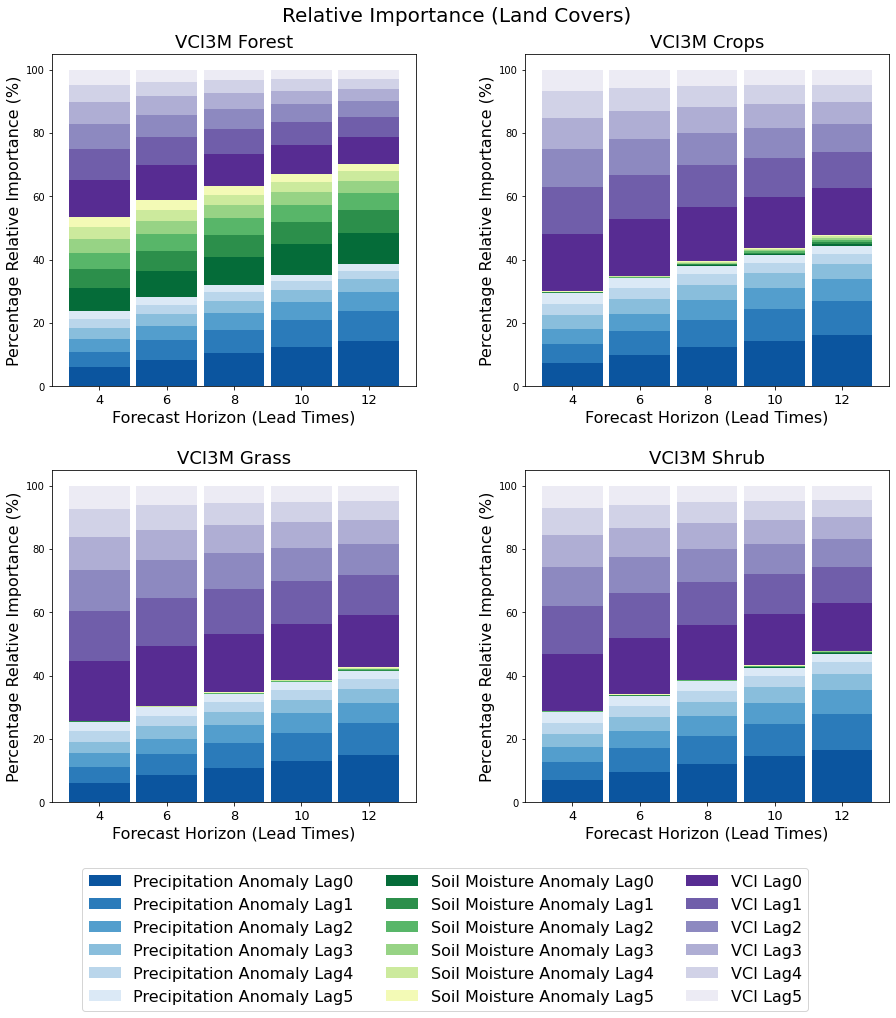

In [5]:
county103 = [
'Marsabit',
'Kitui',
'Baringo',
'Tana-River',
'Turkana',
'Narok'
]

trainDFX = pd.read_csv('LC_Extracts/Merged/Smooth_LCs/LC_3M/HBM_train_df_3M_Sub_pft.csv')
sub_trainDFX = trainDFX.loc[trainDFX.County.isin(county103)]


rel_impDF = calcRelImp(sub_trainDFX, 'LC', 'VCI', anom=True)
plotRelImp(rel_impDF, 'LC', 'VCI', title='Relative Importance (Land Covers)')

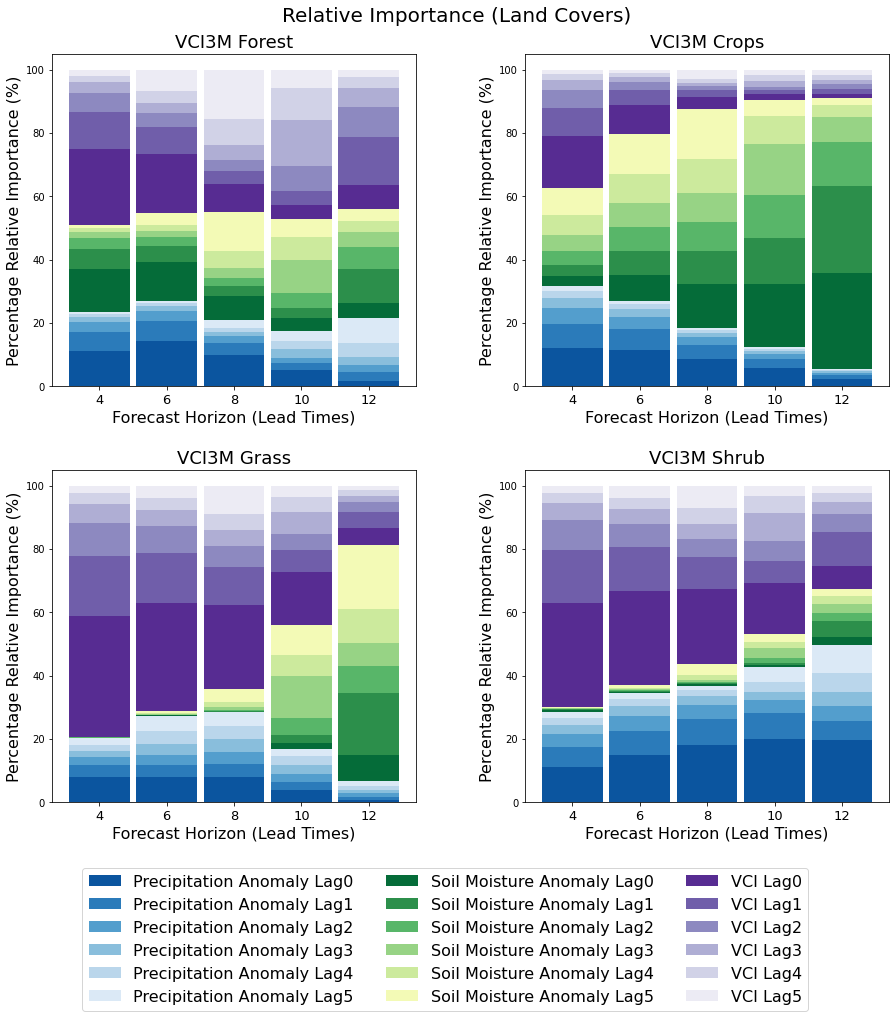

In [553]:
rel_impDF = calcRelImp(sub_trainDFX, 'LC', 'VCI', anom=True, growing_ssn='MAM')
plotRelImp(rel_impDF, 'LC', 'VCI', title='Relative Importance (Land Covers)', ssn='MAM')

In [6]:
# PLOT ROC CURVES
def plotROC(df, name, data):
    FPs,FNs,TPs,TNs = [],[],[],[]
    FPR,TPR = [],[]
    Hor = []

    fig,ax1 = plt.subplots(figsize=(8,8))


#     ax1.set_prop_cycle(plt.cycler('color', ['black', '#1f77b4', '#ff7f0e', '#2ca02c','#d62728']))
    ax1.set_prop_cycle(plt.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#74bfe8']))

    AreaPerWeek = []
    something = 0 

    HWeeks=[4,6,8,10,12]
    for hweek in HWeeks:
        fhor = df[(df['Horizon']==hweek)]
        if data == 'VCI':
            forecast = fhor.VCI_Forecast.values*100
            actual  = fhor.VCI_Observed.values*100
        elif data == 'NDVI':
            forecast = fhor.VCI_Predicted.values
            actual  = fhor.VCI_Observed.values

        FPR,TPR = [],[]
        Hor.append(np.repeat(hweek, len(actual)))

        for VCI in range(0,len(actual)):

                FP,FN,TP,TN = 0,0,0,0

                for item,item2 in zip(actual,forecast): 

                    if item < VCI and item2 <35:
                        TP +=1
                    elif item < VCI and item2 > 35:
                        FP +=1
                    elif item > VCI and item2 < 35:
                        FN +=1
                    elif item > VCI and item2 >35:
                        TN +=1

                FPs.append(FP)
                FNs.append(FN)
                TPs.append(TP)
                TNs.append(TN)
               

                try:
                    TPR.append(TP/(TP+FN))
                except:
                    TPR.append(1)

                try:
                    FPR.append(FP/(FP+TN)) 
                except:
                    FPR.append(0)
                
                if VCI == 34:
                    if something == 0:
                        try:
                            ax1.scatter(FP/(FP+TN),TP/(TP+FN),s=45,label = ('VCI < 35'))    
                            something +=1
                        except:
                            something +=1
                    else:
                        try:
                            ax1.scatter(FP/(FP+TN),TP/(TP+FN),s=45)    
                        except:
                            print('Name')
          
        AUC = np.trapz(TPR,FPR,dx=0.001)        
        ax1.plot(FPR,TPR,label='{} Week forcast time \nAUC = {}'.format(hweek,round(AUC,2)))
            #ax1.plot(FPR,TPR,label =('Week' + str(weeks)+ '\nAUC = ' +str(np.round(AUC,2))))

        AreaPerWeek.append(AUC)

        yx = np.linspace(0,1,10)
        ax1.plot(yx,yx,dashes=[6, 2],color='black')

        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1)
        ax1.legend(fontsize=15)
        ax1.grid(True)
        ax1.set_title(f'ROC {name}', fontsize=16)
        ax1.set_ylabel('True Positive Rate', fontsize=16)
        ax1.set_xlabel('False Positive Rate', fontsize=16)
        plt.savefig(f'../ROC-{name}.pdf',dpi=400, bbox_inches='tight')
        
    #     plt.savefig('{}{}.pdf'.format(file_path,key),dpi=400)
    #     plt.show()
        print(np.array(AreaPerWeek)*100)
        
        pd.DataFrame({'TPR':TPR, 'FPR':FPR}).to_csv(f'ROC_Metrics_{name}_{hweek}.csv')

In [7]:
### MAKE FREQUENCY TABLE FOR RELIABILITY DIAGRM
def getFreqs1(df,forecast_probs,observed_binary, bin_steps=0.2):
    freqs = {'Horizon':[],'FcastProbs':[],'Fcastfreqs':[], 'Obsfreq':[]}
    fps = np.arange(0, 1.1, bin_steps)
    for f in [4,6,8,10,12]:
        subA = df[df['Horizon']==f]
        subB = subA.loc[:,[forecast_probs,observed_binary]]
        for i in fps:
            fcounts1 = [subB[(subB[forecast_probs]>=i)&(subB[forecast_probs]<=i+bin_steps)]]
            freqs['Fcastfreqs'].append(len(fcounts1[0]))
            freqs['Obsfreq'].append(len(fcounts1[0][fcounts1[0][observed_binary]==1]))
            freqs['FcastProbs'].append(i)
            freqs['Horizon'].append(f)
                
    freqs_out = pd.DataFrame(freqs)
    freqs_out['Obs_Freq'] = freqs_out['Obsfreq']/freqs_out['Fcastfreqs']
    return freqs_out

### FUNCTION FOR PICP AND MPIEW 
def getPICI_AR(observed, upper, lower):
    p_upper = upper
    p_lower = lower
    ci = []
    for i in range(len(p_upper)):
        c = p_lower[i] < observed[i] and observed[i] < p_upper[i]
        if c == True:
            ci.append(1)
        else:
            pass
    return sum(ci)/len(p_upper), sum(p_upper-p_lower)/len(p_upper)


def joinDf(dflist):
    VCIO_ls = []
    for v in dflist:
        VCIO_ls.append(pd.read_csv(v))
    return pd.concat(VCIO_ls)

In [8]:
# file = glob.glob('LC_Extracts/Merged/Smooth_LCs/LC_3M/HBM_train_df_3M_Sub_pft.csv')
county103 = [
'Marsabit',
'Kitui',
'Baringo',
'Tana-River',
'Turkana',
'Narok'
]

county101 = [
'West-Pokot',
'Wajir',
'Mandera',
'Samburu',
'Laikipia',
'Kajiado',
'Isiolo',
'Taita-Taveta',
'Garissa',
'Nyeri'
]

UnPool_df = joinDf(glob.glob('../Forecast_Out/Out_New/LC*Unpooled*POnly*csv'))
# Pool_df = joinDf(glob.glob('../Forecast_Out/Out_New/LC*_Pooled*csv'))
partPool_df= joinDf(glob.glob('../Forecast_Out/Out_New/LC*PartPooled*POnly*csv'))

In [10]:
PoolTr = Pool_df[Pool_df.County.isin(county103)]
PartPoolTr = partPool_df[partPool_df.County.isin(county103)]


PoolTran = Pool_df[Pool_df.County.isin(county101)]
PartPoolTran = partPool_df[partPool_df.County.isin(county101)]

In [11]:
for p in [UnPool_df, PoolTr, PartPoolTr]:
    print(p.County.unique())

['Tana-River' 'Turkana' 'Kitui' 'Marsabit' 'Baringo' 'Narok']
['Marsabit' 'Kitui' 'Baringo' 'Tana-River' 'Turkana' 'Narok']
['Marsabit' 'Kitui' 'Baringo' 'Tana-River' 'Turkana' 'Narok']


In [12]:
for c in PartPoolTr.County.unique():
    sub0 = PartPoolTr[PartPoolTr.County==c]
    print(f'{c} | {sub0.LandCover.unique().tolist()}')

Marsabit | ['forest', 'crops', 'grass', 'shrub']
Kitui | ['forest', 'crops', 'grass', 'shrub']
Baringo | ['forest', 'crops', 'grass', 'shrub']
Tana-River | ['forest', 'crops', 'grass', 'shrub']
Turkana | ['forest', 'crops', 'grass', 'shrub']
Narok | ['forest', 'crops', 'grass', 'shrub']


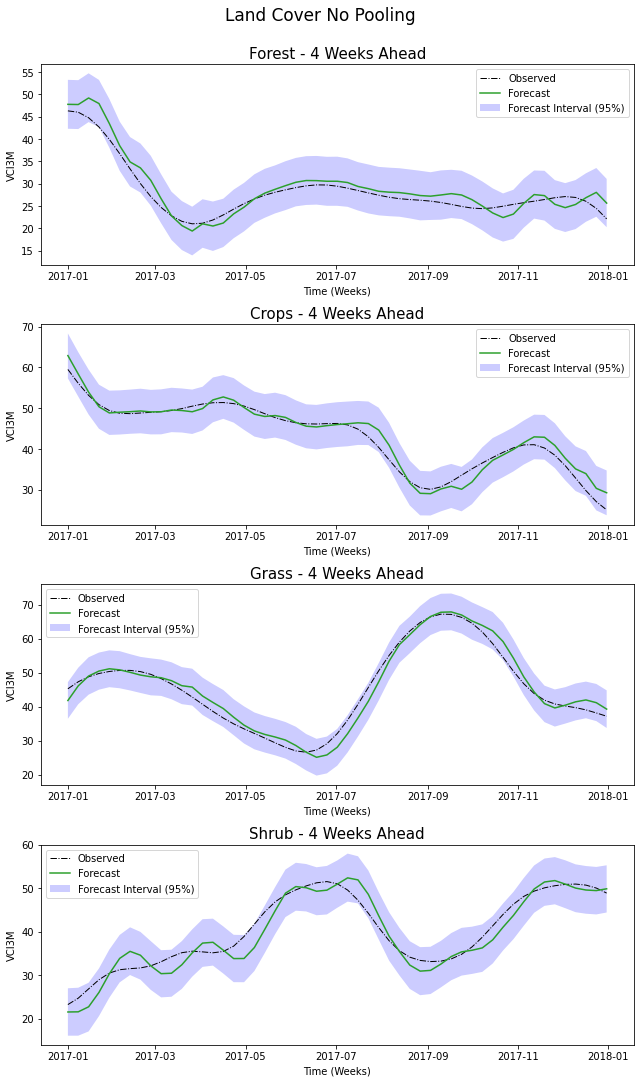

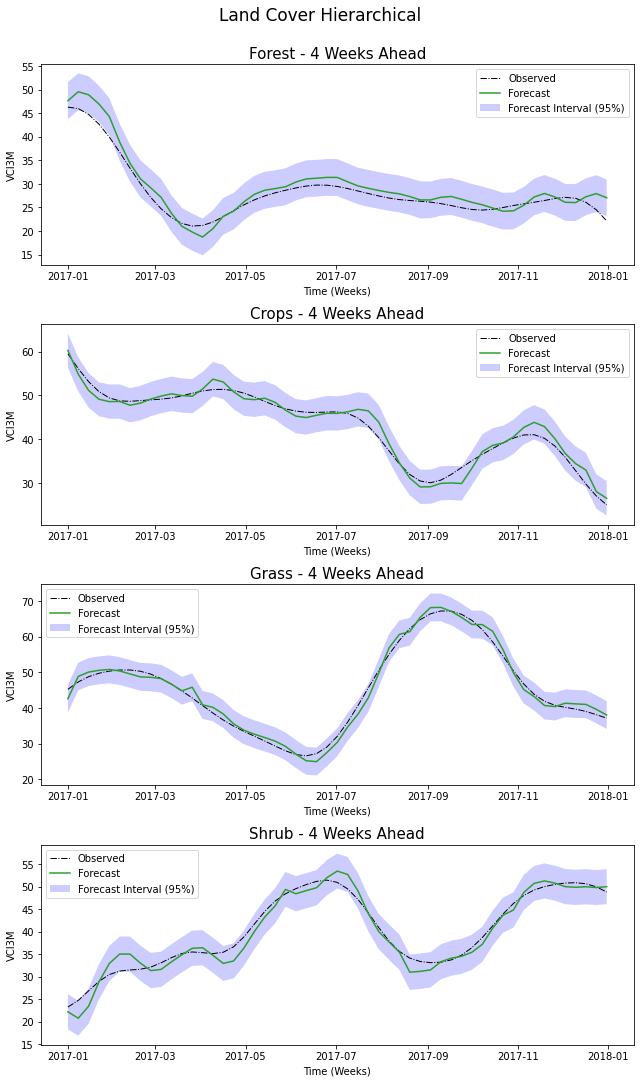

In [13]:
cty = ['Kitui']
color0 = ['#ff7f0e', '#2ca02c','#d62728','#b516a5']
# sub0 = allPredsTrain[(allPredsTrain.County=='Mandera') & (allPredsTrain.Horizon==4)]
sub0 = UnPool_df[(UnPool_df.County.isin(cty)) & (UnPool_df.Horizon==4)]
sub0['Date'] = pd.to_datetime(sub0.Date)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9,15))
fig.suptitle(f'Land Cover No Pooling', y=1.0, fontsize=17)
for a, ax in enumerate(axs.reshape(-1)):
    v = ['forest', 'crops', 'grass', 'shrub'][a]
    sub_data = sub0[sub0.LandCover == v]
    sub_data = sub_data[sub_data.Date.dt.year==2017]
    ax.set_title(f'{v.capitalize()} - 4 Weeks Ahead', fontsize=15)
    ax.plot(sub_data.Date, sub_data.VCI_Observed*100, ls='-.', lw=1, color='k', label='Observed')
    ax.plot(sub_data.Date, sub_data.VCI_Forecast*100, color='#2ca02c', label='Forecast')
    ax.fill_between(sub_data.Date, sub_data.VCI_Upper1*100, sub_data.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('VCI3M')
    ax.legend()
    plt.tight_layout()
plt.savefig(f'../LC_TC_TS3 (No Pooled).pdf',  bbox_inches='tight')


sub0 = PartPoolTr[(PartPoolTr.County.isin(cty)) & (PartPoolTr.Horizon==4)]
sub0['Date'] = pd.to_datetime(sub0.Date)
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9,15))
fig.suptitle(f'Land Cover Hierarchical', y=1.0, fontsize=17)
for a, ax in enumerate(axs.reshape(-1)):
    v = ['forest', 'crops', 'grass', 'shrub'][a]
    sub_data = sub0[sub0.LandCover == v]
    sub_data = sub_data[sub_data.Date.dt.year==2017]
    ax.set_title(f'{v.capitalize()} - 4 Weeks Ahead', fontsize=15)
    ax.plot(sub_data.Date, sub_data.VCI_Observed*100, ls='-.', lw=1, color='k', label='Observed')
    ax.plot(sub_data.Date, sub_data.VCI_Forecast*100, color='#2ca02c', label='Forecast')
    ax.fill_between(sub_data.Date, sub_data.VCI_Upper1*100, sub_data.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    ax.set_xlabel('Time (Weeks)')
    ax.set_ylabel('VCI3M')
    ax.legend()
    plt.tight_layout()
plt.savefig(f'../LC_TC_TS3 (Hierarchical).pdf',  bbox_inches='tight')
# plt.savefig(f'../LC_TC_TS3.png',  bbox_inches='tight')

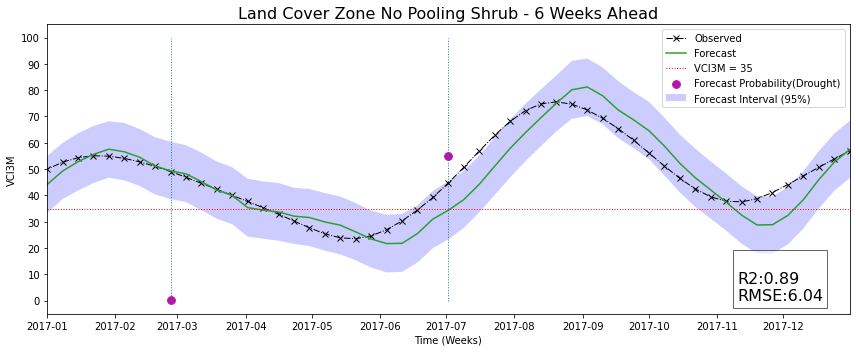

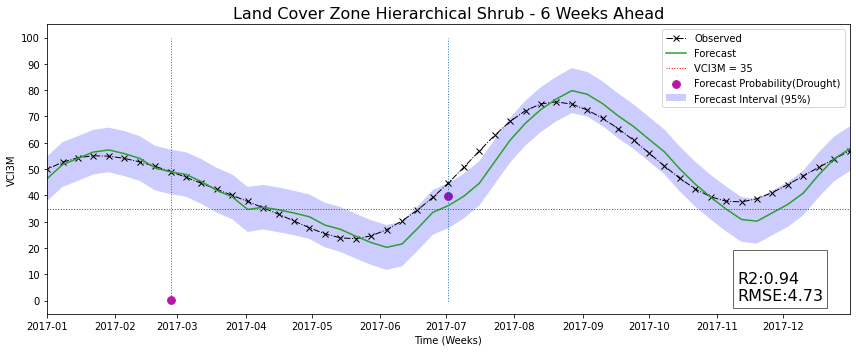

In [14]:
start = datetime.datetime.strptime('2017-01-01','%Y-%m-%d' )
stop = datetime.datetime.strptime('2017-12-31','%Y-%m-%d' )
stop2 = datetime.datetime.strptime('2017-11-10','%Y-%m-%d' )
for z in [(UnPool_df, 'No Pooling'), (PartPoolTr, 'Hierarchical')]:
    h=6
    cty = ['Baringo']
    color0 = ['#ff7f0e', '#2ca02c','#d62728','#b516a5']
    # sub0 = allPredsTrain[(allPredsTrain.County=='Mandera') & (allPredsTrain.Horizon==4)]
    sub0 = z[0][(z[0].County.isin(cty)) & (z[0].Horizon==h)]
    sub0['Date'] = pd.to_datetime(sub0.Date)
    # fig.suptitle(f'Agro Ecological Zone No Pooling', y=1.0, fontsize=17)
    sub_data = sub0[sub0.LandCover == 'grass']
    r2c = r2_score(sub_data['VCI_Observed'], sub_data['VCI_Forecast'])
    rmse3 = np.sqrt(mean_squared_error(sub_data['VCI_Observed'], sub_data['VCI_Forecast']))
    plt.figure(figsize=(12,5))
    plt.title(f'Land Cover Zone {z[1]} {v.capitalize()} - {h} Weeks Ahead', fontsize=16)
    plt.plot(sub_data.Date, sub_data.VCI_Observed*100, marker="x", ls='-.', lw=1, color='k', label='Observed')
    plt.plot(sub_data.Date, sub_data.VCI_Forecast*100, color='#2ca02c', label='Forecast')

#     use_prods = sub_data.where(sub_data['FDrought']>0.5)
#     use_prods = use_prods.where(use_prods['FDrought']<0.95)
    use_prods_1=sub_data[sub_data.Date=='2017-02-26']
    use_prods_2=sub_data[sub_data.Date=='2017-07-02']
    plt.scatter(use_prods_1.Date, use_prods_1['FDrought']*100, marker="o", color='#b516a5',s=60, label='Forecast Probability(Drought)')
    plt.scatter(use_prods_2.Date, use_prods_2['FDrought']*100, marker="o", color='#b516a5', s=60)
    plt.fill_between(sub_data.Date, sub_data.VCI_Upper1*100, sub_data.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
    plt.xlabel('Time (Weeks)')
    plt.ylabel('VCI3M')
    plt.yticks(np.arange(0, 101, 10))
    plt.xlim((start,stop))
    plt.vlines(use_prods_1['Date'],0,100, ls=':', lw=1)
    plt.vlines(use_prods_2['Date'],0,100, ls=':', lw=1)
    plt.axhline(35, ls=':', lw=1, color='r', label='VCI3M = 35')
    txt0 = plt.text(x=stop2, y=0.05, s=f'\nR2:{r2c.round(2)}\nRMSE:{(rmse3*100).round(2)}', fontsize=16)
    txt0.set_bbox(dict(facecolor='white', alpha=0.6))
    plt.legend(loc='best')
    plt.tight_layout()
#     plt.savefig(f'AEZ_TS_{h} ({z[1]}).pdf',  bbox_inches='tight')

In [10]:
# allPredsAnom.to_csv('HBM_Forecast-test.csv')
pcounty_UP = []
for c in county103:
    subData2 = UnPool_df[UnPool_df.County==c]
    for lc in subData2.LandCover.unique():
        subData1 = subData2[subData2.LandCover==lc]
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
        for a, ax in enumerate(axs.reshape(-1)):
            h = [4,6,8,10,12][a]
            subData = subData1[subData1.Horizon==h]

            sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

            r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
            mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
            rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
            pcounty_UP.append(pd.DataFrame({'County':[c], 'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'No Pooling'}))
            ax.plot((0,1), (0,1), 'k--', lw=2.5)
            ax.set_title(f'{c} {lc} -UnPooled', fontsize=16)
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)

            ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
            ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

            txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
            txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
            plt.legend([],[], frameon=False)
            #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

pcounty_P = []
for c in county103:
    subData2 = PoolTr[PoolTr.County==c]

    for lc in subData2.LandCover.unique():
        subData1 = subData2[subData2.LandCover==lc]
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
        for a, ax in enumerate(axs.reshape(-1)):
            h = [4,6,8,10,12][a]
            subData = subData1[subData1.Horizon==h]

            sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

            r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
            mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
            rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
            pcounty_P.append(pd.DataFrame({'County':[c],'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Complete Pooling'}))
            ax.plot((0,1), (0,1), 'k--', lw=2.5)
            ax.set_title(f'{c} {lc} - Pooled', fontsize=16)
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)

            ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
            ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

            txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
            txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
            plt.legend([],[], frameon=False)
            #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

pcounty_PP = []
for c in county103:
    subData2 = PartPoolTr[PartPoolTr.County==c]
    for lc in subData2.LandCover.unique():
        subData1 = subData2[subData2.LandCover==lc]
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
        for a, ax in enumerate(axs.reshape(-1)):
            h = [4,6,8,10,12][a]
            subData = subData1[subData1.Horizon==h]

            sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

            r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
            mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
            rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
            pcounty_PP.append(pd.DataFrame({'County':[c],'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Hierarchical'}))
            ax.plot((0,1), (0,1), 'k--', lw=2.5)
            ax.set_title(f'{c} {lc} -PartPooled', fontsize=16)
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)

            ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
            ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

            txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
            txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
            plt.legend([],[], frameon=False)
            #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

NameError: name 'county103' is not defined

In [561]:
pmetricsUP = pd.concat(pcounty_UP)
pmetricsP = pd.concat(pcounty_P)
pmetricsPP = pd.concat(pcounty_PP)
pall_metrics = pd.concat([pmetricsUP, pmetricsP, pmetricsPP])
pall_metrics.head()

County LandCover  Hor        R2       MAE      RMSE     FC_Type
0  Marsabit    forest    4  0.993112  0.016318  0.019192  No Pooling
0  Marsabit    forest    6  0.965702  0.037312  0.043101  No Pooling
0  Marsabit    forest    8  0.910231  0.060365  0.070208  No Pooling
0  Marsabit    forest   10  0.826888  0.082385  0.098140  No Pooling
0  Marsabit    forest   12  0.725572  0.100136  0.124329  No Pooling

In [11]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
for a, ax in enumerate(axs.reshape(-1)):
    m = county103[a]
    sub_lc1 = pmetricsUP[pmetricsUP.County == m]
    sub_lc2 = pmetricsPP[pmetricsPP.County == m]
    for i, z in enumerate(lcs):
        sub_lc3 = sub_lc1[sub_lc1.LandCover == z]
        sub_lc4 = sub_lc2[sub_lc2.LandCover == z]
        ax.plot(sub_lc3['Hor'], sub_lc3['R2'], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc4['Hor'], sub_lc4['R2'], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    
    ax.set_title(f'{m} Land Cover $R^2$', fontsize=16)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
# plt.savefig('../R2_RMSE_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [1]:
# allPredsAnom.to_csv('HBM_Forecast-test.csv')
county_UP = []
for lc in UnPool_df.LandCover.unique():
    subData1 = UnPool_df[UnPool_df.LandCover==lc]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
    for a, ax in enumerate(axs.reshape(-1)):
        h = [4,6,8,10,12][a]
        subData = subData1[subData1.Horizon==h]

        sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

        r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
        mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
        rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
        county_UP.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'No Pooling'}))
        ax.plot((0,1), (0,1), 'k--', lw=2.5)
        ax.set_title(f'{lc} -UnPooled', fontsize=16)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
        ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

        txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
        txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
        plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

county_PP = []
for lc in PartPoolTr.LandCover.unique():
    subData1 = PartPoolTr[PartPoolTr.LandCover==lc]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
    for a, ax in enumerate(axs.reshape(-1)):
        h = [4,6,8,10,12][a]
        subData = subData1[subData1.Horizon==h]

        sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

        r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
        mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
        rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
        county_PP.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Hierarchical'}))
        ax.plot((0,1), (0,1), 'k--', lw=2.5)
        ax.set_title(f'{lc} -PartPooled', fontsize=16)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
        ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

        txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
        txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
        plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

NameError: name 'UnPool_df' is not defined

In [564]:
UnPool_dfSSN = addSeason(UnPool_df)
PartPoolTrSSN = addSeason(PartPoolTr)

UnPool_dfMAM = UnPool_dfSSN[UnPool_dfSSN.Season=='mam']
UnPool_dfOND = UnPool_dfSSN[UnPool_dfSSN.Season=='ond']

PartPoolTrMAM = PartPoolTrSSN[PartPoolTrSSN.Season=='mam']
PartPoolTrOND = PartPoolTrSSN[PartPoolTrSSN.Season=='ond']

In [15]:
# allPredsAnom.to_csv('HBM_Forecast-test.csv')
pcounty_UPMAM = []
for c in county103:
    subData2 = UnPool_dfMAM[UnPool_dfMAM.County==c]
    for lc in subData2.LandCover.unique():
        subData1 =subData2[subData2.LandCover==lc]
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
        for a, ax in enumerate(axs.reshape(-1)):
            h = [4,6,8,10,12][a]
            subData = subData1[subData1.Horizon==h]

            sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

            r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
            mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
            rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
            pcounty_UPMAM.append(pd.DataFrame({'County':[c],'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'No Pooling'}))
            ax.plot((0,1), (0,1), 'k--', lw=2.5)
            ax.set_title(f'{lc} -UnPooled', fontsize=16)
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)

            ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
            ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

            txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
            txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
            plt.legend([],[], frameon=False)
            #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

pcounty_PPMAM = []
for c in county103:
    subData2 = PartPoolTrMAM[PartPoolTrMAM.County==c]
    for lc in subData2.LandCover.unique():
        subData1 = subData2[subData2.LandCover==lc]
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
        for a, ax in enumerate(axs.reshape(-1)):
            h = [4,6,8,10,12][a]
            subData = subData1[subData1.Horizon==h]

            sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

            r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
            mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
            rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
            pcounty_PPMAM.append(pd.DataFrame({'County':[c],'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Hierarchical'}))
            ax.plot((0,1), (0,1), 'k--', lw=2.5)
            ax.set_title(f'{lc} -PartPooled', fontsize=16)
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)

            ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
            ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

            txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
            txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
            plt.legend([],[], frameon=False)
            #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

# allPredsAnom.to_csv('HBM_Forecast-test.csv')
pcounty_UPOND = []
for c in county103:
    subData2 = UnPool_dfOND[UnPool_dfOND.County==c]
    for lc in subData2.LandCover.unique():
        subData1 =subData2[subData2.LandCover==lc]
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
        for a, ax in enumerate(axs.reshape(-1)):
            h = [4,6,8,10,12][a]
            subData = subData1[subData1.Horizon==h]

            sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

            r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
            mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
            rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
            pcounty_UPOND.append(pd.DataFrame({'County':[c],'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'No Pooling'}))
            ax.plot((0,1), (0,1), 'k--', lw=2.5)
            ax.set_title(f'{lc} -UnPooled', fontsize=16)
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)

            ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
            ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

            txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
            txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
            plt.legend([],[], frameon=False)
            #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

pcounty_PPOND = []
for c in county103:
    subData2 = PartPoolTrOND[PartPoolTrOND.County==c]
    for lc in subData2.LandCover.unique():
        subData1 = subData2[subData2.LandCover==lc]
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
        for a, ax in enumerate(axs.reshape(-1)):
            h = [4,6,8,10,12][a]
            subData = subData1[subData1.Horizon==h]

            sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

            r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
            mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
            rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
            pcounty_PPOND.append(pd.DataFrame({'County':[c],'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Hierarchical'}))
            ax.plot((0,1), (0,1), 'k--', lw=2.5)
            ax.set_title(f'{lc} -PartPooled', fontsize=16)
            ax.set_ylim(0,1)
            ax.set_xlim(0,1)

            ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
            ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

            txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
            txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
            plt.legend([],[], frameon=False)
            #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

NameError: name 'county103' is not defined

In [567]:
pmetricsUPMAM = pd.concat(pcounty_UPMAM)
pmetricsPPMAM = pd.concat(pcounty_PPMAM)

pmetricsUPOND = pd.concat(pcounty_UPOND)
pmetricsPPOND = pd.concat(pcounty_PPOND)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
for a, ax in enumerate(axs.reshape(-1)):
    m = county103[a]
    sub_lc1 = pmetricsUPMAM[pmetricsUPMAM.County == m]
    sub_lc2 = pmetricsPPMAM[pmetricsPPMAM.County == m]
    for i, z in enumerate(lcs):
        sub_lc3 = sub_lc1[sub_lc1.LandCover == z]
        sub_lc4 = sub_lc2[sub_lc2.LandCover == z]
        ax.plot(sub_lc3['Hor'], sub_lc3['R2'], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc4['Hor'], sub_lc4['R2'], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    
    ax.set_title(f'{m} Land Cover $R^2$', fontsize=16)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
# plt.savefig('../R2_RMSE_LC3.pdf', bbox_inches='tight')

In [12]:
# allPredsAnom.to_csv('HBM_Forecast-test.csv')
county_UPMAM = []
for lc in UnPool_dfMAM.LandCover.unique():
    subData1 = UnPool_dfMAM[UnPool_dfMAM.LandCover==lc]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
    for a, ax in enumerate(axs.reshape(-1)):
        h = [4,6,8,10,12][a]
        subData = subData1[subData1.Horizon==h]

        sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

        r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
        mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
        rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
        county_UPMAM.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'No Pooling'}))
        ax.plot((0,1), (0,1), 'k--', lw=2.5)
        ax.set_title(f'{lc} -UnPooled', fontsize=16)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
        ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

        txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
        txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
        plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

county_PPMAM = []
for lc in PartPoolTrMAM.LandCover.unique():
    subData1 = PartPoolTrMAM[PartPoolTrMAM.LandCover==lc]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
    for a, ax in enumerate(axs.reshape(-1)):
        h = [4,6,8,10,12][a]
        subData = subData1[subData1.Horizon==h]

        sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

        r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
        mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
        rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
        county_PPMAM.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Hierarchical'}))
        ax.plot((0,1), (0,1), 'k--', lw=2.5)
        ax.set_title(f'{lc} -PartPooled', fontsize=16)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
        ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

        txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
        txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
        plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

# allPredsAnom.to_csv('HBM_Forecast-test.csv')
county_UPOND = []
for lc in UnPool_dfOND.LandCover.unique():
    subData1 = UnPool_dfOND[UnPool_dfOND.LandCover==lc]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
    for a, ax in enumerate(axs.reshape(-1)):
        h = [4,6,8,10,12][a]
        subData = subData1[subData1.Horizon==h]

        sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

        r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
        mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
        rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
        county_UPOND.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'No Pooling'}))
        ax.plot((0,1), (0,1), 'k--', lw=2.5)
        ax.set_title(f'{lc} -UnPooled', fontsize=16)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
        ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

        txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
        txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
        plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

county_PPOND = []
for lc in PartPoolTrOND.LandCover.unique():
    subData1 = PartPoolTrOND[PartPoolTrOND.LandCover==lc]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
    for a, ax in enumerate(axs.reshape(-1)):
        h = [4,6,8,10,12][a]
        subData = subData1[subData1.Horizon==h]

        sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

        r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
        mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
        rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
        county_PPOND.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Hierarchical'}))
        ax.plot((0,1), (0,1), 'k--', lw=2.5)
        ax.set_title(f'{lc} -PartPooled', fontsize=16)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
        ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

        txt0 = ax.text(x=0.5, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
        txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
        plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

NameError: name 'UnPool_dfMAM' is not defined

In [685]:
metricsUP = pd.concat(county_UP)
metricsP = pd.concat(county_P)
metricsPP = pd.concat(county_PP)
all_metrics = pd.concat([metricsUP, metricsPP])
all_metrics.head()

LandCover  Hor        R2       MAE      RMSE     FC_Type
0    forest    4  0.989489  0.016719  0.021259  No Pooling
0    forest    6  0.949137  0.036629  0.046760  No Pooling
0    forest    8  0.876854  0.056824  0.072915  No Pooling
0    forest   10  0.778424  0.076600  0.098192  No Pooling
0    forest   12  0.664566  0.094097  0.121399  No Pooling

In [570]:
metricsUPMAM = pd.concat(county_UPMAM)
metricsPPMAM = pd.concat(county_PPMAM)

metricsUPOND = pd.concat(county_UPOND)
metricsPPOND = pd.concat(county_PPOND)
# all_metrics = pd.concat([metricsUP, metricsP, metricsPP])
# all_metrics.head()

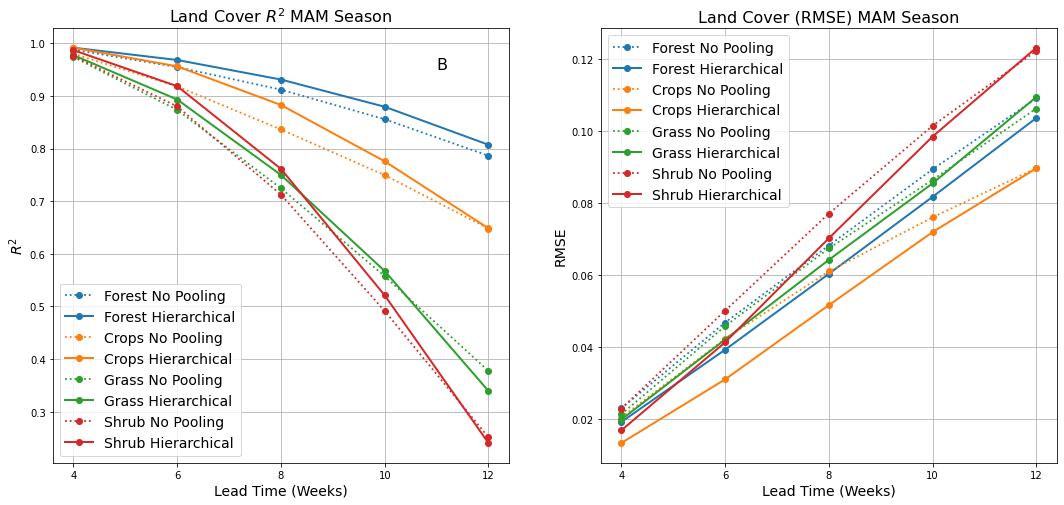

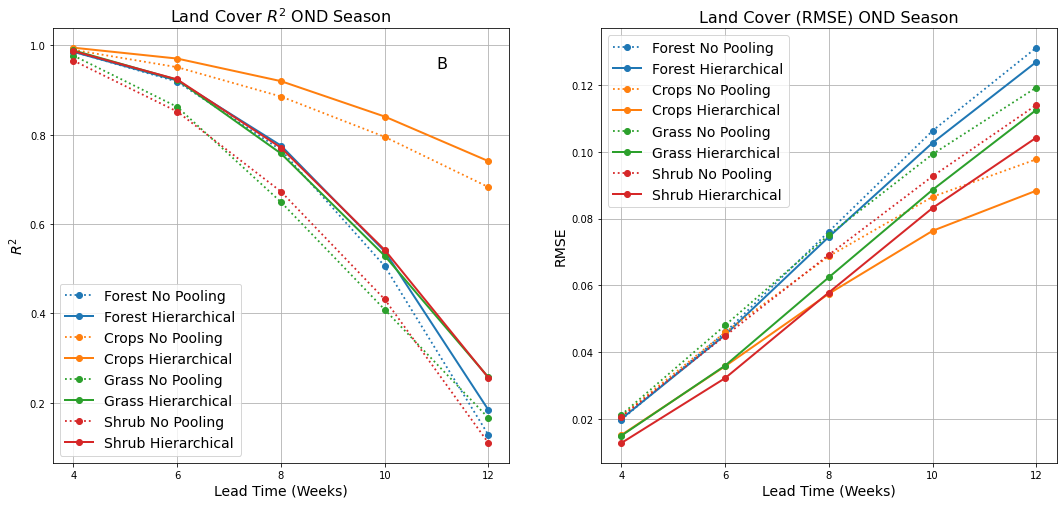

In [539]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(lcs):
        sub_lc1 = metricsUPMAM[metricsUPMAM.LandCover == z]
        sub_lc2 = metricsPPMAM[metricsPPMAM.LandCover == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    if m== 'R2':
        ax.set_title('Land Cover $R^2$ MAM Season', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='B', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_title('Land Cover (RMSE) MAM Season', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('../MAM_R2_RMSE_LC3.pdf', bbox_inches='tight')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(lcs):
        sub_lc1 = metricsUPOND[metricsUPOND.LandCover == z]
        sub_lc2 = metricsPPOND[metricsPPOND.LandCover == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    if m== 'R2':
        ax.set_title('Land Cover $R^2$ OND Season', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='B', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_title('Land Cover (RMSE) OND Season', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('../OND_R2_RMSE_LC3.pdf', bbox_inches='tight')

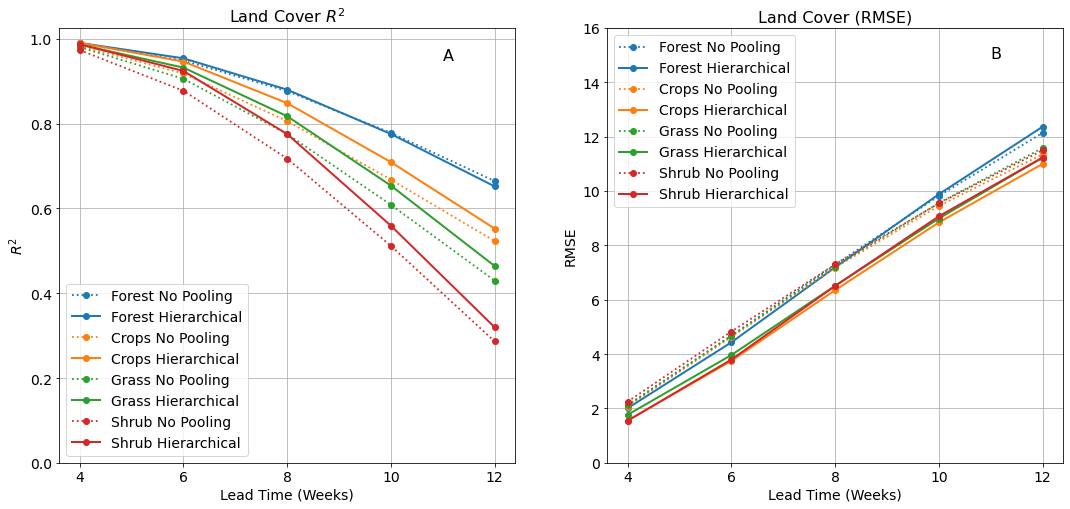

In [686]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(lcs):
        sub_lc1 = metricsUP[metricsUP.LandCover == z]
        sub_lc1['RMSE'] = sub_lc1['RMSE']*100
        sub_lc2 = metricsPP[metricsPP.LandCover == z]
        sub_lc2['RMSE'] = sub_lc2['RMSE']*100
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    ax.set_xticklabels(np.arange(4, 13, 2), fontsize=14)
    if m== 'R2':
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_title('Land Cover $R^2$', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='A', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        ax.set_yticks(np.arange(0,17, 2))
        ax.set_yticklabels(np.round(np.arange(0, 17, 2),1), fontsize=14)
        ax.set_title('Land Cover (RMSE)', fontsize=16)
        txt0 = ax.text(x=11.0, y=14.9, s='B', fontsize=16)
        ax.legend(loc='best', fontsize=14)
plt.savefig('../R2_RMSE_LC3.pdf', bbox_inches='tight')

In [688]:
all_metrics['RMSE'] = all_metrics['RMSE']*100
all_metrics.pivot_table(columns=['Hor'], values=['R2','RMSE'], index=['FC_Type','LandCover'])

R2                                          \
Hor                           4         6         8         10        12   
FC_Type      LandCover                                                     
Hierarchical crops      0.990766  0.946543  0.848473  0.709330  0.552389   
             forest     0.990646  0.954332  0.880340  0.775666  0.652057   
             grass      0.986551  0.932340  0.817613  0.653820  0.464082   
             shrub      0.987530  0.924408  0.775484  0.559229  0.319544   
No Pooling   crops      0.983562  0.918495  0.806259  0.667873  0.523105   
             forest     0.989489  0.949137  0.876854  0.778424  0.664566   
             grass      0.980742  0.905874  0.775778  0.608488  0.429704   
             shrub      0.973691  0.877656  0.717596  0.511676  0.286190   

                            RMSE                                           
Hor                           4         6         8         10         12  
FC_Type      LandCover                                                     
Hierarchical crops      1.551969  3.749453  6.350729  8.842850  10.997035  
             forest     2.005463  4.430760  7.187604  9.880119  12.364203  
             grass      1.764639  3.963095  6.510673  8.988087  11.228149  
             shrub      1.547509  3.794862  6.505973  9.068368  11.229049  
No Pooling   crops      2.070748  4.629773  7.181065  9.452459  11.351071  
             forest     2.125905  4.676008  7.291534  9.819188  12.139902  
             grass      2.111634  4.674369  7.218844  9.558486  11.582685  
             shrub      2.247818  4.827816  7.296660  9.545023  11.500971

In [2]:
# allPredsAnom.to_csv('HBM_Forecast-test.csv')
# county_PTrf = []
# for lc in PoolTran.LandCover.unique():
#     subData1 = PoolTran[PoolTran.LandCover==lc]
#     fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
#     for a, ax in enumerate(axs.reshape(-1)):
#         h = [4,6,8,10,12][a]
#         subData = subData1[subData1.Horizon==h]

#         sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

#         r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
#         mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
#         rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
#         county_PTrf.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Non Trained Counties'}))
#         ax.plot((0,1), (0,1), 'k--', lw=2.5)
#         ax.set_title(f'{lc} -tPooled', fontsize=16)
#         ax.set_ylim(0,1)
#         ax.set_xlim(0,1)

#         ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
#         ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

#         txt0 = ax.text(x=0.6, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
#         txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
#         plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')
# allPredsAnom.to_csv('HBM_Forecast-test.csv')
county_PPTrf = []
for lc in PartPoolTran.LandCover.unique():
    subData1 = PartPoolTran[PartPoolTran.LandCover==lc]
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
    for a, ax in enumerate(axs.reshape(-1)):
        h = [4,6,8,10,12][a]
        subData = subData1[subData1.Horizon==h]

        sns.kdeplot(subData['VCI_Forecast'], subData['VCI_Observed'], cmap='YlGn', ax=ax)

        r2c = r2_score(subData['VCI_Observed'], subData['VCI_Forecast'])
        mae3 = mean_absolute_error(subData['VCI_Observed'], subData['VCI_Forecast'])
        rmse3 = np.sqrt(mean_squared_error(subData['VCI_Observed'], subData['VCI_Forecast']))
        county_PPTrf.append(pd.DataFrame({'LandCover':[lc], 'Hor':[h],'R2':[r2c], 'MAE':[mae3], 'RMSE':[rmse3], 'FC_Type':'Non Trained Counties'}))
        ax.plot((0,1), (0,1), 'k--', lw=2.5)
        ax.set_title(f'{lc} -PartPooled', fontsize=16)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)

        ax.set_xlabel(f'VCI Forecast at {h} Weeks', fontsize=12)
        ax.set_ylabel(f'VCI Observed at {h} Weeks', fontsize=12)

        txt0 = ax.text(x=0.6, y=0.05, s=f'R2:{r2c.round(3)}\nMAE:{mae3.round(3)}\nRMSE:{rmse3.round(3)}', fontsize=16)
        txt0.set_bbox(dict(facecolor='white', alpha=0.6))    
        plt.legend([],[], frameon=False)
        #         plt.savefig(f'{lc}-PartPooled_4LCs_{c}.png')

NameError: name 'PartPoolTran' is not defined

In [663]:
# metricsPTrf = pd.concat(county_PTrf)
metricsPPTrf = pd.concat(county_PPTrf)
metricsPPTrf['RMSE'] = metricsPPTrf['RMSE']*100

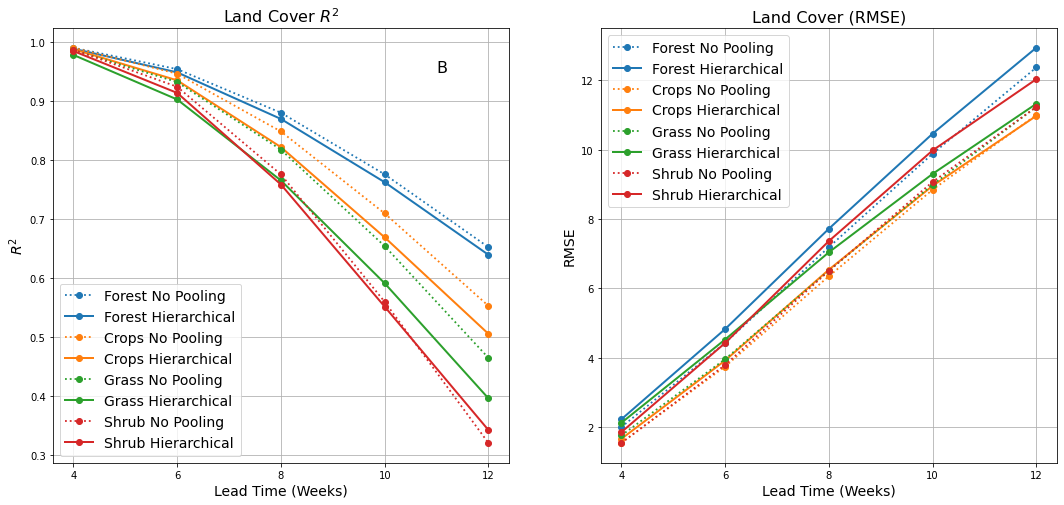

In [664]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
tc_pp = all_metrics[all_metrics.FC_Type == 'Hierarchical']
ntc_pp = metricsPPTrf
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
for a, ax in enumerate(axs.reshape(-1)):
    m = ['R2','RMSE'][a]
    n = ['$R^2$','RMSE'][a]
    for i, z in enumerate(lcs):
        sub_lc1 = tc_pp[tc_pp.LandCover == z]
        sub_lc2 = ntc_pp[ntc_pp.LandCover == z]
        ax.plot(sub_lc1['Hor'], sub_lc1[m], label=f'{z.capitalize()} No Pooling',ls=':', color=colors[i], lw=1.8, marker='o')
        ax.plot(sub_lc2['Hor'], sub_lc2[m], label=f'{z.capitalize()} Hierarchical', lw=2, color=colors[i], marker='o')
    ax.set_ylabel(n, fontsize=14)
    ax.set_xticks(np.arange(4, 13, 2))
    if m== 'R2':
        ax.set_title('Land Cover $R^2$', fontsize=16)
        txt0 = ax.text(x=11.0, y=0.95, s='A', fontsize=16)
        ax.legend(loc='lower left', fontsize=14)
    ax.grid()
    ax.set_xlabel('Lead Time (Weeks)', fontsize=14)
    if m== 'RMSE':
        txt0 = ax.text(x=11.0, y=13, s='B', fontsize=16)
        ax.set_title('Land Cover (RMSE)', fontsize=16)
        ax.legend(loc='best', fontsize=14)
# plt.savefig('../R2_RMSE_LC3.pdf', bbox_inches='tight')

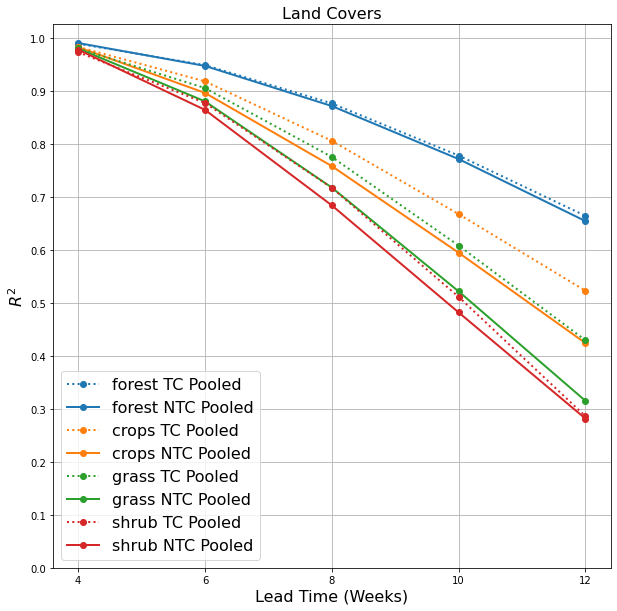

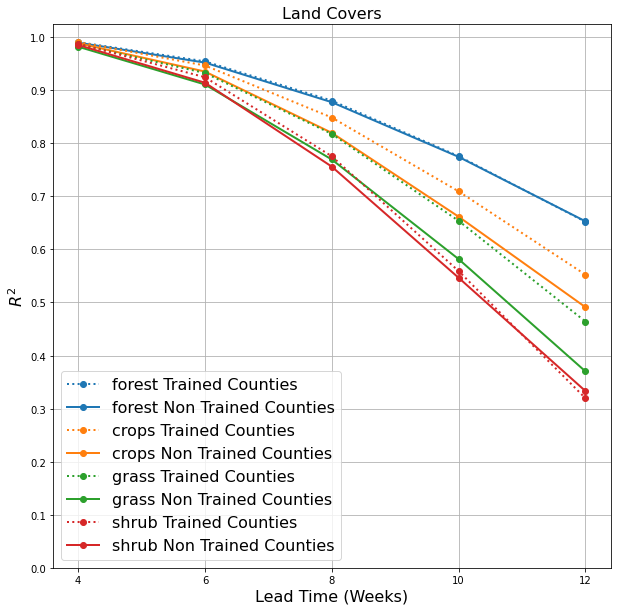

In [578]:
# for a in [('TC','Trained Counties'), ('NTC', 'Non Trained Counties')]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
tc_p = all_metrics[all_metrics.FC_Type == 'No Pooling']
ntc_p = metricsPTrf
plt.figure(figsize=(10, 10))
for i, l in enumerate(['forest','crops','grass', 'shrub']):
    sub_0 = tc_p[tc_p.LandCover == l]
    sub_1 = ntc_p[ntc_p.LandCover == l]
    plt.title('Land Covers', fontsize=16)
    plt.plot(sub_0['Hor'], sub_0['R2'], color=colors[i], label=f'{l} TC Pooled', marker='o', ls=':', lw=2)
    plt.plot(sub_1['Hor'], sub_1['R2'], color=colors[i], label=f'{l} NTC Pooled', marker='o',lw=2)
    plt.ylabel('$R^2$', fontsize=16)
    plt.xlabel('Lead Time (Weeks)', fontsize=16) 
    plt.grid(True)
    plt.xticks(np.arange(4, 13, 2))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend(loc='lower left', fontsize=16)
# plt.savefig('../LCR2_Compare03.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('../LCR2_Compare03.png', dpi=300, bbox_inches='tight')

# for a in [('TC','Trained Counties'), ('NTC', 'Non Trained Counties')]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#b516a5']
tc_pp = all_metrics[all_metrics.FC_Type == 'Hierarchical']
ntc_pp = metricsPPTrf
plt.figure(figsize=(10, 10))
for i, l in enumerate(['forest','crops','grass', 'shrub']):
    sub_0 = tc_pp[tc_pp.LandCover == l]
    sub_1 = ntc_pp[ntc_pp.LandCover == l]
    plt.title('Land Covers', fontsize=16)
    plt.plot(sub_0['Hor'], sub_0['R2'], color=colors[i], label=f'{l} Trained Counties', marker='o', ls=':', lw=2)
    plt.plot(sub_1['Hor'], sub_1['R2'], color=colors[i], label=f'{l} Non Trained Counties', marker='o',lw=2)
    plt.ylabel('$R^2$', fontsize=16)
    plt.xlabel('Lead Time (Weeks)', fontsize=16) 
    plt.grid(True)
    plt.xticks(np.arange(4, 13, 2))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend(loc='lower left', fontsize=16)
plt.savefig('../TransLCR2_Compare03.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('../LCR2_Compare03.png', dpi=300, bbox_inches='tight')

In [14]:
for x in ['forest','crops','grass', 'shrub']:
    sublc = UnPool_df[UnPool_df.LandCover==x]
    print(len(sublc))
    plotROC(sublc,f'VCI ({x}) No Pooling', 'VCI' )

NameError: name 'UnPool_df' is not defined

In [13]:
for x in ['forest','crops','grass', 'shrub']:
    sublc = PartPoolTr[PartPoolTr.LandCover==x]
    print(len(sublc))
    plotROC(sublc,f'VCI ({x}) Hierarchical', 'VCI')

NameError: name 'PartPoolTr' is not defined

In [15]:
roc_filesNP = glob.glob('ROC_Metrics_VCI*No Pooling*csv')
roc_filesHM = glob.glob('ROC_Metrics_VCI*Hierarchical*csv')
roc_filesNP+roc_filesHM

['ROC_Metrics_VCI (forest) No Pooling_4.csv',
 'ROC_Metrics_VCI (forest) No Pooling_6.csv',
 'ROC_Metrics_VCI (shrub) No Pooling_8.csv',
 'ROC_Metrics_VCI (grass) No Pooling_12.csv',
 'ROC_Metrics_VCI (grass) No Pooling_10.csv',
 'ROC_Metrics_VCI (crops) No Pooling_10.csv',
 'ROC_Metrics_VCI (crops) No Pooling_12.csv',
 'ROC_Metrics_VCI (crops) No Pooling_8.csv',
 'ROC_Metrics_VCI (grass) No Pooling_8.csv',
 'ROC_Metrics_VCI (grass) No Pooling_6.csv',
 'ROC_Metrics_VCI (crops) No Pooling_6.csv',
 'ROC_Metrics_VCI (forest) No Pooling_10.csv',
 'ROC_Metrics_VCI (forest) No Pooling_12.csv',
 'ROC_Metrics_VCI (crops) No Pooling_4.csv',
 'ROC_Metrics_VCI (grass) No Pooling_4.csv',
 'ROC_Metrics_VCI (shrub) No Pooling_6.csv',
 'ROC_Metrics_VCI (shrub) No Pooling_4.csv',
 'ROC_Metrics_VCI (shrub) No Pooling_10.csv',
 'ROC_Metrics_VCI (forest) No Pooling_8.csv',
 'ROC_Metrics_VCI (shrub) No Pooling_12.csv',
 'ROC_Metrics_VCI (grass) Hierarchical_8.csv',
 'ROC_Metrics_VCI (forest) Hierarchical_

In [16]:
roc_filesHM[0].split('_')[-1]

'8.csv'

In [17]:
roc_filesNP[0].split(' ')[1][1:-1]

'forest'

In [18]:
def joinROC(files):
    df_ls = []
    for f in files:
        hor = f.split(')')[1].split('_')[1][:-4]
        model = f.split(')')[1].split('_')[0][1:]
        lc = f.split(' ')[1][1:-1]
        df = pd.read_csv(f)
        df['Threshold'] = df.index
        df['Horizon'] = np.repeat(int(hor), len(df))
        df['Model'] = np.repeat(model, len(df))
        df['LandCover'] = np.repeat(lc, len(df))
        
        df_ls.append(df)
    return pd.concat(df_ls)

In [20]:
roc_df2 = roc_df[roc_df.Model=='No Pooling']
roc_df3 = roc_df[roc_df.Model=='Hierarchical']

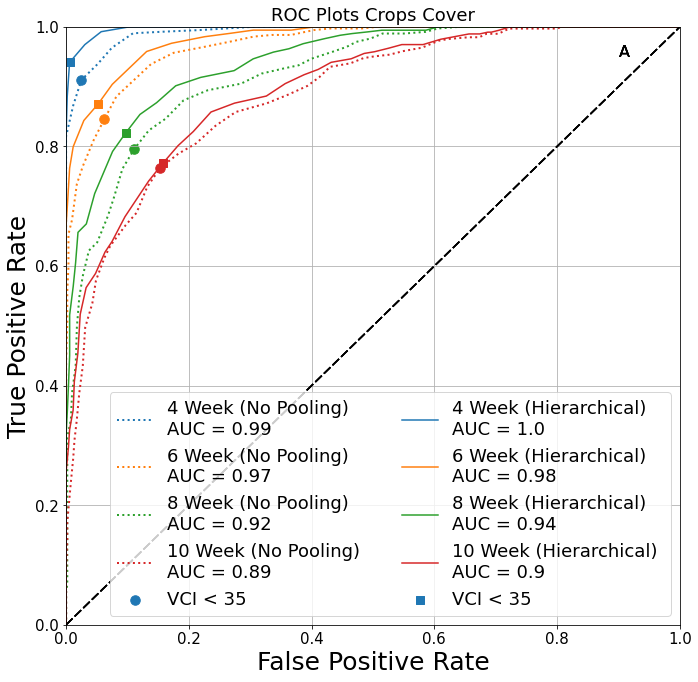

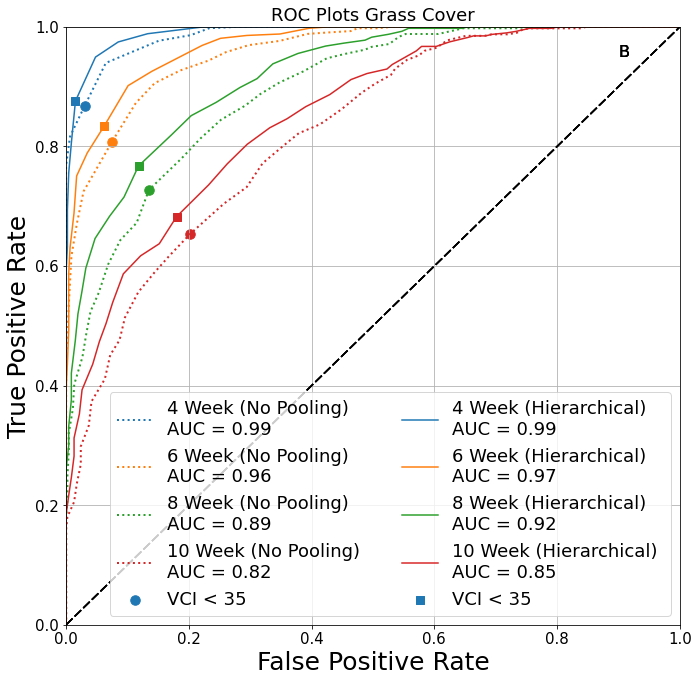

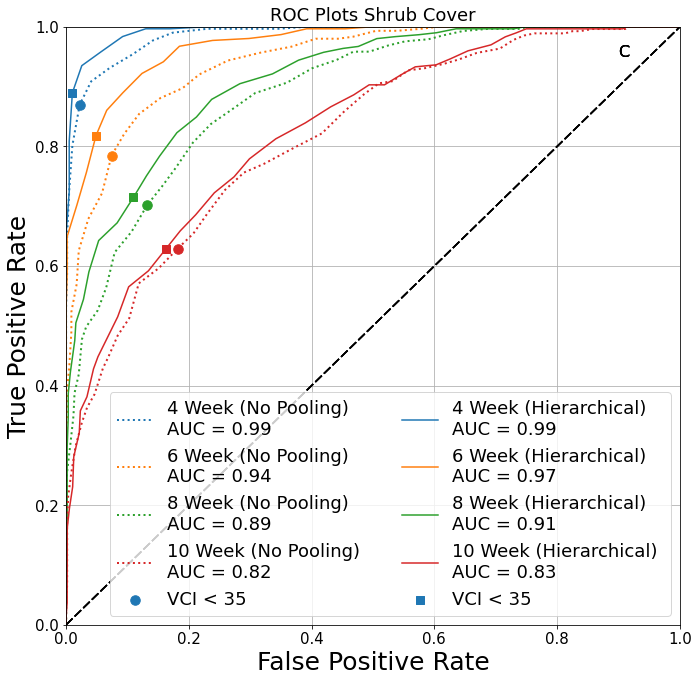

In [23]:
for l, a in zip(['crops', 'grass', 'shrub'], ['A','B','C']):
    plt.figure(figsize=(11,11))
    for i, h in enumerate([4,6,8,10]):
        sub_0 = roc_df2[(roc_df2.LandCover==l)&(roc_df2.Horizon==h)]
        sub_1 = roc_df3[(roc_df3.LandCover==l)&(roc_df3.Horizon==h)]

        AUC0 = np.trapz(sub_0.TPR,sub_0.FPR,dx=0.001)
        AUC1 = np.trapz(sub_1.TPR,sub_1.FPR,dx=0.001)


        plt.plot(sub_0.FPR, sub_0.TPR, ls=':',lw=2, color=colors[i], label=f'{h} Week (No Pooling) \nAUC = {round(AUC0,2)}')
        plt.plot(sub_1.FPR, sub_1.TPR, ls='-',color=colors[i],label=f'{h} Week (Hierarchical) \nAUC = {round(AUC1,2)}')

        plt.scatter(sub_0[sub_0.Threshold==34].FPR, sub_0[sub_0.Threshold==34].TPR,s=90, marker='o', color=colors[i], label = ('VCI < 35')) 
        plt.scatter(sub_1[sub_1.Threshold==34].FPR, sub_1[sub_1.Threshold==34].TPR,s=60,  marker='s', color=colors[i], label = ('VCI < 35'))

        yx = np.linspace(0,1,10)
        plt.plot(yx,yx, dashes=[6, 2],color='black')

        plt.title(f'ROC Plots {l.capitalize()} Cover', fontsize=18)
        plt.xlim(0,1)
        plt.ylim(0,1)
    #     plt.legend(fontsize=13)
        plt.grid(True)
        plt.ylabel('True Positive Rate', fontsize=25)
        plt.xlabel('False Positive Rate', fontsize=25)
        plt.yticks(fontsize=15)
        plt.xticks( fontsize=15)
        plt.text(x=0.9, y=0.95, s=a, fontsize=16)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,4,6,8,1,3,5,7,9]
    plt.legend([handles[o] for o in order],[labels[o] for o in order], ncol=2, loc='lower right', fontsize=18)
    plt.savefig(f'../{l}_Joint_ROC_Plots3.pdf', dpi=300, bbox_inches='tight')

In [651]:
th35 = []
for i in [4,6,8,10,12]:
    sub_th = roc_df[roc_df.Horizon==i]
    sub_th2 = sub_th[sub_th.Threshold==34]
    sub_th3 = sub_th2[sub_th2.LandCover.isin(lcs)]
    th35.append(sub_th3)
th350= pd.concat(th35)

In [652]:
piv350 = th350.pivot_table(index=['Model','LandCover'], columns=['Horizon'], values=['TPR', 'FPR'])
piv350

FPR                                          \
Horizon                       4         6         8         10        12   
Model        LandCover                                                     
Hierarchical crops      0.005725  0.052124  0.097087  0.157390  0.204887   
             forest     0.010903  0.031447  0.073438  0.120427  0.171344   
             grass      0.015251  0.062366  0.118026  0.180043  0.238197   
             shrub      0.010239  0.048780  0.109735  0.162791  0.224561   
No Pooling   crops      0.024857  0.062378  0.111328  0.153696  0.217726   
             forest     0.009404  0.044961  0.080495  0.116923  0.156951   
             grass      0.030238  0.074398  0.134956  0.202614  0.257511   
             shrub      0.022147  0.074138  0.132530  0.181818  0.241497   

                             TPR                                          
Horizon                       4         6         8         10        12  
Model        LandCover                                                    
Hierarchical crops      0.940541  0.870879  0.822535  0.771513  0.742038  
             forest     0.920635  0.890244  0.834783  0.787129  0.710059  
             grass      0.875862  0.834532  0.767327  0.682620  0.623684  
             shrub      0.889610  0.818182  0.714754  0.628763  0.539855  
No Pooling   crops      0.911051  0.845528  0.796089  0.764535  0.700306  
             forest     0.910156  0.886076  0.834821  0.778846  0.740113  
             grass      0.867749  0.807059  0.727273  0.654135  0.600000  
             shrub      0.869707  0.784768  0.702422  0.629091  0.523256

In [653]:
piv350.index

MultiIndex([('Hierarchical',  'crops'),
            ('Hierarchical', 'forest'),
            ('Hierarchical',  'grass'),
            ('Hierarchical',  'shrub'),
            (  'No Pooling',  'crops'),
            (  'No Pooling', 'forest'),
            (  'No Pooling',  'grass'),
            (  'No Pooling',  'shrub')],
           names=['Model', 'LandCover'])

In [654]:
piv350.columns = [f'{a}_{b}' for a, b in piv350.columns]
tpr = [c for c in piv350.columns if 'TPR' in c ]
far = [c for c in piv350.columns if 'FPR' in c ]

roc_dict = pd.DataFrame()
for i, w in zip(tpr, far):
    c  = piv350.index
    n = piv350[i].values*100
    m = piv350[w].values*100
    roc_dict['LandCover'] = [f'{t[0]} {t[1].capitalize()}' for t in c] 
    roc_dict[i]=[f'{int(v.round(0))} ({int(u.round(0))})' for v, u in zip(n, m)]

In [657]:
roc_dict.to_csv('../lc_roc.csv')

In [3]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#74bfe8']
for x in ['forest','crops','grass', 'shrub']:
    subaez = allPreds[allPreds.LandCover==x]
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    for a, ax in enumerate(axs.reshape(-1)):
        cols = (['FNo-Drought', 'Obs_No-Drought'],['FDrought','Obs_Drought'])[a]
        freqs_out = getFreqs1(subaez, cols[0], cols[1], 0.2)
        bss = []
        print(cols)
        for i, h in enumerate([4,6,8,10,12]):
            sub_step = freqs_out[freqs_out['Horizon']==h]
            sub_data = subaez[subaez['Horizon']==h]
            sub_step['Threshold'] = f'{cols[1][4:]}'
            freq_ls.append(sub_step)
            brier_score = brier_score_loss(sub_data[cols[1]], sub_data[cols[0]], pos_label=1)
            bss.append(brier_score)
            ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
            ax.set_title(f'{cols[1][4:]} Event | {x}', fontsize=16)
            ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
            ax.set_ylabel("Observed Relative Frequency", fontsize=13)
            ax.set_xlabel("Forecast Probality", fontsize=13)
            ax.set_ylim([0, 1.0])
            ax.set_xlim([0, 1.0])
            ax.grid(True)
            ax.legend(loc='lower right', fontsize=12)
            axins = inset_axes(ax, width="80%", height="40%",
                           bbox_to_anchor=(0.08, 0.58, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
            axins.tick_params(left=True, right=False, labelleft=True, labelright=False)
            axins.plot(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i], marker='o')
            if h != 12:
                axins.set_yticks([])
                axins.set_xticks([])
            else:
                axins.set_yticks(np.arange(2, 9, 2))
                axins.set_xticks(np.arange(0, 1.1, 0.2))
                axins.set_ylabel('$Log_{10}$ Samples')
        txt = ax.text(x=0.23, y=0.03, s=f'Brier Score 4 Week: {bss[0].round(3)}\nBrier Score 6 Week: {bss[1].round(3)}\nBrier Score 8 Week: {bss[2].round(3)}\nBrier Score 10 Week: {bss[3].round(3)}\nBrier Score 12 Week: {bss[4].round(3)}', fontsize=12)
        txt.set_bbox(dict(facecolor='white', alpha=0.6))
        plt.savefig(f'Reliability_Plot_{x}_weeks3.png', bbox_inches='tight', transparent=True)

NameError: name 'allPreds' is not defined

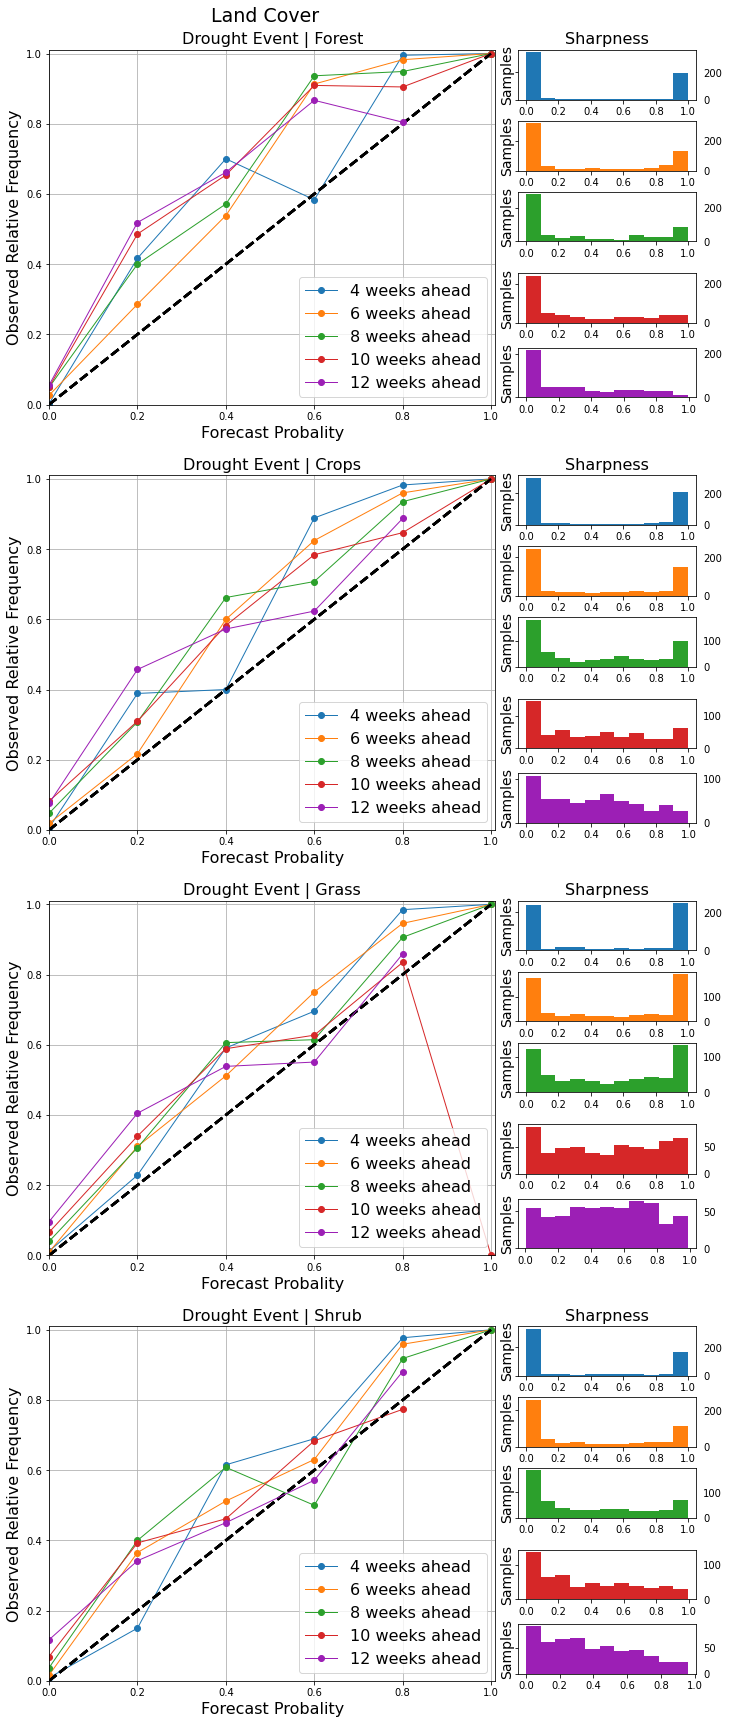

In [232]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 30))
fig.suptitle(f'Land Cover', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = lcs[a]
    subaez = UnPool_df[UnPool_df.LandCover==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.4,.2,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['LandCover'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="80%", height="35%",
                           bbox_to_anchor=(1.05, p, .5, .4),
#                            
                          bbox_transform=ax.transAxes, loc=2, borderpad=0)
        axins.tick_params(left=True, right=False, labelleft=False, labelright=True),
#         axins.bar(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i])
        if h == 4:
            axins.set_title(f'Sharpness', fontsize=16),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11)
        
#         axins.set_yticks(np.arange(2, 9, 2))
        axins.set_xticks(np.arange(0, 1.1, 0.2))
        axins.set_ylabel('Samples', fontsize=14)
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
# plt.savefig(f'../Reliability_Plot_LC3.pdf', bbox_inches='tight')

In [4]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 30))
fig.suptitle(f'Land Cover', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = lcs[a]
    subaez = PartPoolTr[PartPoolTr.LandCover==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.4,.2,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['LandCover'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="80%", height="35%",
                           bbox_to_anchor=(1.05, p, .5, .4),
#                            
                          bbox_transform=ax.transAxes, loc=2, borderpad=0)
        axins.tick_params(left=True, right=False, labelleft=False, labelright=True),
#         axins.bar(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i])
        if h == 4:
            axins.set_title(f'Sharpness', fontsize=16),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11)
        
#         axins.set_yticks(np.arange(2, 9, 2))
        axins.set_xticks(np.arange(0, 1.1, 0.2))
        axins.set_ylabel('Samples', fontsize=14)
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
plt.savefig(f'../Reliability_Plot_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [5]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 18))
fig.suptitle(f'Land Cover (Hierarchical)', y=0.92, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = ['crops', 'grass'][a]
    n = ['C', 'D'][a]
    subaez = PartPoolTr[PartPoolTr.LandCover==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.39,.18,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['LandCover'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.text(x=0.1, y=0.9, s=n, fontsize=16)
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if h in [4,6,8,10]:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True, labelbottom=False)
        if h == 4:
            axins.set_title(f'Sharpness',fontsize=15),
        if h == 12:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
            axins.set_xlabel("Forecast Probality", fontsize=15),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11, ec="k")
        
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
plt.savefig(f'../Hierarchical_Reliability_Plot_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [6]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 18))
fig.suptitle(f'Land Cover (No Pooling)', y=0.92, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = ['crops', 'grass'][a]
    n = ['A', 'B'][a]
    subaez = UnPool_df[UnPool_df.LandCover==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.39,.18,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['LandCover'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()}', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.text(x=0.1, y=0.9, s=n, fontsize=16)
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2),1), fontsize=14)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="100%", height="40%",
                           bbox_to_anchor=(1.05, p, .5, .4),
                           bbox_transform=ax.transAxes, loc=2, borderpad=0)
        if h in [4,6,8,10]:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True, labelbottom=False)
        if h == 4:
            axins.set_title(f'Sharpness',fontsize=15),
        if h == 12:
            axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
            axins.set_xlabel("Forecast Probality", fontsize=15),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11, ec="k")
        
# plt.savefig(f'../Reliability_Plot_LC3.png', bbox_inches='tight')
plt.savefig(f'../No_Pooling_Reliability_Plot_LC3.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [7]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 30))
fig.suptitle(f'Land Cover', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = lcs[a]
    subaez = mamTrain[mamTrain.LandCover==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.2)
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.4,.2,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['LandCover'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()} (MAM Season)', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="80%", height="35%",
                           bbox_to_anchor=(1.05, p, .5, .4),
#                            
                          bbox_transform=ax.transAxes, loc=2, borderpad=0)
        axins.tick_params(left=True, right=False, labelleft=False, labelright=True),
#         axins.bar(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i])
        if h == 4:
            axins.set_title(f'Sharpness', fontsize=16),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11)
        
#         axins.set_yticks(np.arange(2, 9, 2))
        axins.set_xticks(np.arange(0, 1.1, 0.2))
        axins.set_ylabel('Samples', fontsize=14)
plt.savefig(f'../Reliability_Plot_LC3_MAM.png', bbox_inches='tight')
plt.savefig(f'../Reliability_Plot_LC3_MAM.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [8]:
freq_ls = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9c1fb5']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 30))
fig.suptitle(f'Land Cover', y=0.9, fontsize=19)
for a, ax in enumerate(axs.reshape(-1)):
    x = lcs[a]
    subaez = ondTrain[ondTrain.LandCover==x]
    freqs_out = getFreqs1(subaez,'FDrought','Obs_Drought', 0.25)
    bss = []
    for i, h in enumerate([4,6,8,10,12]):
        p = [.6,.4,.2,-.03,-.24][i]
        sub_step = freqs_out[freqs_out['Horizon']==h]
        sub_data = subaez[subaez['Horizon']==h]
        sub_step['Threshold'] = 'Drought'
        sub_step['LandCover'] = x
        freq_ls.append(sub_step)
#         brier_score = brier_score_loss(sub_data['Obs_Drought'], sub_data['FDrought'], pos_label=1)
#         bss.append(brier_score)
        ax.plot((0,1), (0,1), 'k--', lw=2.5 , color='black')
        ax.set_title(f'Drought Event | {x.capitalize()} (OND Season)', fontsize=16)
        ax.plot(sub_step.FcastProbs, sub_step.Obs_Freq, marker='o', lw=1, color=colors[i], label=f'{h} weeks ahead')
        ax.set_ylabel("Observed Relative Frequency", fontsize=16)
        ax.set_xlabel("Forecast Probality", fontsize=16)
        ax.set_ylim([0, 1.01])
        ax.set_xlim([0, 1.01])
        ax.grid(True)
        ax.legend(loc='lower right', fontsize=16)
        axins = inset_axes(ax, width="80%", height="35%",
                           bbox_to_anchor=(1.05, p, .5, .4),
#                            
                          bbox_transform=ax.transAxes, loc=2, borderpad=0)
        axins.tick_params(left=True, right=False, labelleft=False, labelright=True),
#         axins.bar(sub_step.FcastProbs, np.log(sub_step.Fcastfreqs), color=colors[i])
        if h == 4:
            axins.set_title(f'Sharpness', fontsize=16),
        axins.hist(sub_data.FDrought.values, color=colors[i], bins=11)
        
#         axins.set_yticks(np.arange(2, 9, 2))
        axins.set_xticks(np.arange(0, 1.1, 0.2))
        axins.set_ylabel('Samples', fontsize=14)
plt.savefig(f'../Reliability_Plot_LC3_OND.png', bbox_inches='tight')
plt.savefig(f'../Reliability_Plot_LC3_OND.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [9]:
outMet = {'County':[],'LC':[],'Horizon':[], 'PICP':[], 'MPIW':[]}
for c in UnPool_df.County.unique():
    sub1 = UnPool_df[UnPool_df.County==c]
    for z in ['forest','crops','grass', 'shrub']:
        sub = sub1[sub1.LandCover==z]
        for h in [4,6,8,10,12]:
            sub0 = sub[sub.Horizon==h]
            PICP, MPIW = getPICI_AR(sub0['VCI_Observed'].values, sub0['VCI_Upper1'].values, sub0['VCI_Lower0'].values)
            outMet['County'].append(c)
            outMet['LC'].append(z)
            outMet['Horizon'].append(h)
            outMet['PICP'].append(PICP)
            outMet['MPIW'].append(MPIW)
UnPooloutMetDF = pd.DataFrame(outMet)

NameError: name 'UnPool_df' is not defined

In [600]:
outMet = {'County':[],'LC':[],'Horizon':[], 'PICP':[], 'MPIW':[]}
for c in PoolTr.County.unique():
    sub1 = PoolTr[PoolTr.County==c]
    for z in ['forest','crops','grass', 'shrub']:
        sub = sub1[sub1.LandCover==z]
        for h in [4,6,8,10,12]:
            sub0 = sub[sub.Horizon==h]
            PICP, MPIW = getPICI_AR(sub0['VCI_Observed'].values, sub0['VCI_Upper1'].values, sub0['VCI_Lower0'].values)
            outMet['County'].append(c)
            outMet['LC'].append(z)
            outMet['Horizon'].append(h)
            outMet['PICP'].append(PICP)
            outMet['MPIW'].append(MPIW)
PooloutMetDF = pd.DataFrame(outMet)

In [691]:
outMet = {'County':[],'LC':[],'Horizon':[], 'PICP':[], 'MPIW':[]}
for c in PartPoolTr.County.unique():
    sub1 = PartPoolTr[PartPoolTr.County==c]
    for z in ['forest','crops','grass', 'shrub']:
        sub = sub1[sub1.LandCover==z]
        for h in [4,6,8,10,12]:
            sub0 = sub[sub.Horizon==h]
            PICP, MPIW = getPICI_AR(sub0['VCI_Observed'].values, sub0['VCI_Upper1'].values, sub0['VCI_Lower0'].values)
            outMet['County'].append(c)
            outMet['LC'].append(z)
            outMet['Horizon'].append(h)
            outMet['PICP'].append(PICP)
            outMet['MPIW'].append(MPIW)
outMetDF = pd.DataFrame(outMet)

In [602]:
outMetDF.head()

County      LC  Horizon      PICP      MPIW
0  Marsabit  forest        4  0.926174  0.078323
1  Marsabit  forest        6  0.931973  0.169936
2  Marsabit  forest        8  0.931034  0.273470
3  Marsabit  forest       10  0.944056  0.370884
4  Marsabit  forest       12  0.936170  0.456585

In [692]:
mns = []
cty = []
for s in lcs:
    sub_MetDF = UnPooloutMetDF[UnPooloutMetDF.LC==s]

    CI = sub_MetDF.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County', 'LC'])
    CI.loc[f'Mean_{s}'] = CI.mean()
    mns.append(CI.loc[f'Mean_{s}'].to_frame().T)
    cty.append(CI)
UPICP_means = pd.concat(mns)
UPICP_county = pd.concat(cty)
UPICP_county.columns = [f'{a}_{b}' for a, b in UPICP_county.columns]
UPICP_county['County'] = [c[0] for c in UPICP_county.index]
UPICP_county['LC'] = [c[1] for c in UPICP_county.index]
UPICP_county = UPICP_county.reset_index(drop=True)

In [604]:
mns = []
cty = []
for s in lcs:
    sub_MetDF = PooloutMetDF[PooloutMetDF.LC==s]

    CI = sub_MetDF.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County', 'LC'])
    CI.loc[f'Mean_{s}'] = CI.mean()
    mns.append(CI.loc[f'Mean_{s}'].to_frame().T)
    cty.append(CI)
PICP_means = pd.concat(mns)
PICP_county = pd.concat(cty)
PICP_county.columns = [f'{a}_{b}' for a, b in PICP_county.columns]
PICP_county['County'] = [c[0] for c in PICP_county.index]
PICP_county['LC'] = [c[1] for c in PICP_county.index]
PICP_county = PICP_county.reset_index(drop=True)

In [693]:
mns = []
cty = []
for s in lcs:
    sub_MetDF = outMetDF[outMetDF.LC==s]

    CI = sub_MetDF.pivot_table(columns=['Horizon'], values=['PICP','MPIW'], index=['County', 'LC'])
    CI.loc[f'Mean_{s}'] = CI.mean()
    mns.append(CI.loc[f'Mean_{s}'].to_frame().T)
    cty.append(CI)
PPICP_means = pd.concat(mns)
PPICP_county = pd.concat(cty)
PPICP_county.columns = [f'{a}_{b}' for a, b in PPICP_county.columns]
PPICP_county['County'] = [c[0] for c in PPICP_county.index]
PPICP_county['LC'] = [c[1] for c in PPICP_county.index]
PPICP_county = PPICP_county.reset_index(drop=True)

In [204]:
PICP_county[PICP_county.County=='Baringo']

MPIW_4    MPIW_6    MPIW_8   MPIW_10   MPIW_12    PICP_4    PICP_6  \
0   0.078094  0.191769  0.301096  0.397409  0.486395  0.979866  0.959184   
5   0.078152  0.191781  0.299940  0.397150  0.482522  0.973154  0.959184   
10  0.078037  0.192881  0.299566  0.397867  0.485243  0.953020  0.904762   
15  0.077777  0.192479  0.298568  0.396084  0.482379  0.979866  0.959184   

      PICP_8   PICP_10   PICP_12   County      LC  
0   0.931034  0.902098  0.865248  Baringo  forest  
5   0.951724  0.909091  0.872340  Baringo   crops  
10  0.889655  0.916084  0.893617  Baringo   grass  
15  0.951724  0.923077  0.914894  Baringo   shrub

In [171]:
PICP_means

MPIW                                              PICP  \
Horizon            4         6         8         10        12        4    
Mean_forest  0.062006  0.152027  0.265700  0.370180  0.462125  0.976510   
Mean_crops   0.062177  0.151569  0.264629  0.369743  0.461608  0.958054   
Mean_grass   0.062147  0.151916  0.264437  0.370565  0.459408  0.961409   
Mean_shrub   0.062168  0.151918  0.264166  0.370722  0.459806  0.978188   

                                                     
Horizon            6         8         10        12  
Mean_forest  0.960884  0.934483  0.926573  0.939716  
Mean_crops   0.960884  0.967241  0.961538  0.948582  
Mean_grass   0.960884  0.956897  0.961538  0.952128  
Mean_shrub   0.977891  0.972414  0.973776  0.966312

In [77]:
county102

['Turkana',
 'West-Pokot',
 'Wajir',
 'Samburu',
 'Tana-River',
 'Laikipia',
 'Narok',
 'Kitui',
 'Kakamega',
 'Isiolo',
 'Taita-Taveta']

In [696]:
UPICP_means.columns = [f'{a}_{b}' for a, b in UPICP_means.columns]
CP = [c for c in UPICP_means.columns if 'PICP' in c ]
MPIW = [c for c in UPICP_means.columns if 'MPIW' in c ]

uci_dict = pd.DataFrame()
for i, w in zip(CP, MPIW):
    c  = UPICP_means.index
    n = UPICP_means[i].values
    m = UPICP_means[w].values
    uci_dict['LC'] = c
    uci_dict[i]=[f'{v.round(2)} ({u.round(2)})' for v, u in zip(n, m)]

In [694]:
PICP_means.columns = [f'{a}_{b}' for a, b in PICP_means.columns]
CP = [c for c in PICP_means.columns if 'PICP' in c ]
MPIW = [c for c in PICP_means.columns if 'MPIW' in c ]

ci_dict = pd.DataFrame()
for i, w in zip(CP, MPIW):
    c  = PICP_means.index
    n = PICP_means[i].values
    m = PICP_means[w].values
    ci_dict['LC'] = c
    ci_dict[i]=[f'{v.round(2)} ({u.round(2)})' for v, u in zip(n, m)]

In [700]:
uci_dict['Model'] = 'BARDL'

In [608]:
ci_dict

LC        PICP_4        PICP_6        PICP_8       PICP_10  \
0  Mean_forest  0.965(0.078)  0.964(0.192)    0.947(0.3)  0.928(0.397)   
1   Mean_crops  0.968(0.078)  0.971(0.192)    0.969(0.3)  0.958(0.397)   
2   Mean_grass  0.978(0.078)  0.968(0.193)     0.96(0.3)  0.967(0.397)   
3   Mean_shrub  0.975(0.078)  0.971(0.192)  0.974(0.299)  0.974(0.397)   

        PICP_12  
0   0.92(0.484)  
1  0.952(0.484)  
2  0.959(0.484)  
3   0.97(0.484)

In [697]:
PPICP_means.columns = [f'{a}_{b}' for a, b in PPICP_means.columns]
CP = [c for c in PPICP_means.columns if 'PICP' in c ]
MPIW = [c for c in PPICP_means.columns if 'MPIW' in c ]

pci_dict = pd.DataFrame()
for i, w in zip(CP, MPIW):
    c  = PPICP_means.index
    n = PPICP_means[i].values
    m = PPICP_means[w].values
    pci_dict['LC'] = c
    pci_dict[i]=[f'{v.round(2)} ({u.round(2)})' for v, u in zip(n, m)]

In [701]:
pci_dict['Model'] = 'HBARDL'

In [703]:
all_picp = pd.concat([uci_dict, pci_dict])
all_picp

LC       PICP_4       PICP_6       PICP_8      PICP_10  \
0  Mean_forest  0.97 (0.09)  0.96 (0.19)  0.95 (0.29)  0.95 (0.38)   
1   Mean_crops  0.97 (0.09)  0.95 (0.19)  0.94 (0.29)  0.95 (0.38)   
2   Mean_grass  0.97 (0.09)  0.96 (0.19)  0.96 (0.29)  0.97 (0.38)   
3   Mean_shrub  0.96 (0.09)  0.96 (0.19)  0.96 (0.29)  0.96 (0.38)   
0  Mean_forest  0.94 (0.08)  0.93 (0.17)  0.94 (0.27)  0.94 (0.37)   
1   Mean_crops  0.99 (0.08)  0.97 (0.17)  0.96 (0.27)  0.95 (0.37)   
2   Mean_grass  0.98 (0.08)  0.97 (0.17)  0.96 (0.27)  0.96 (0.37)   
3   Mean_shrub  0.98 (0.08)  0.98 (0.17)  0.98 (0.27)  0.97 (0.37)   

       PICP_12   Model  
0  0.94 (0.46)   BARDL  
1  0.95 (0.46)   BARDL  
2  0.96 (0.46)   BARDL  
3  0.96 (0.46)   BARDL  
0  0.94 (0.46)  HBARDL  
1  0.95 (0.46)  HBARDL  
2  0.95 (0.46)  HBARDL  
3  0.96 (0.46)  HBARDL

In [705]:
all_picp.to_csv('../LC_PICP.csv')

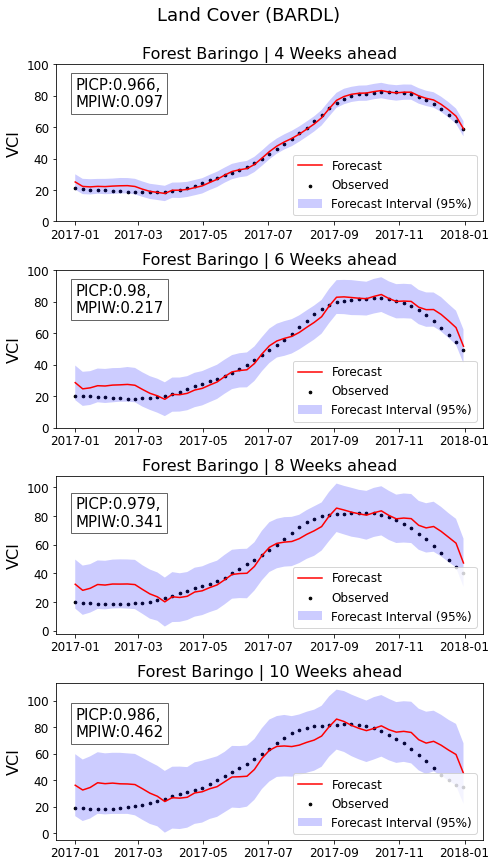

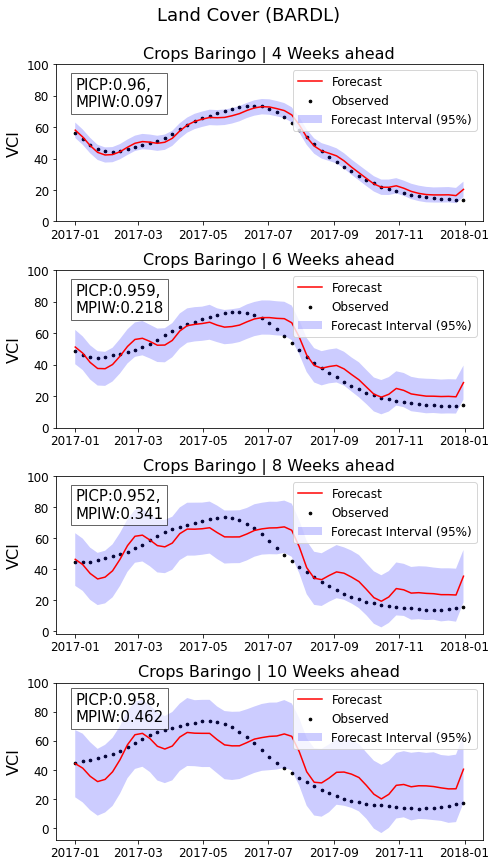

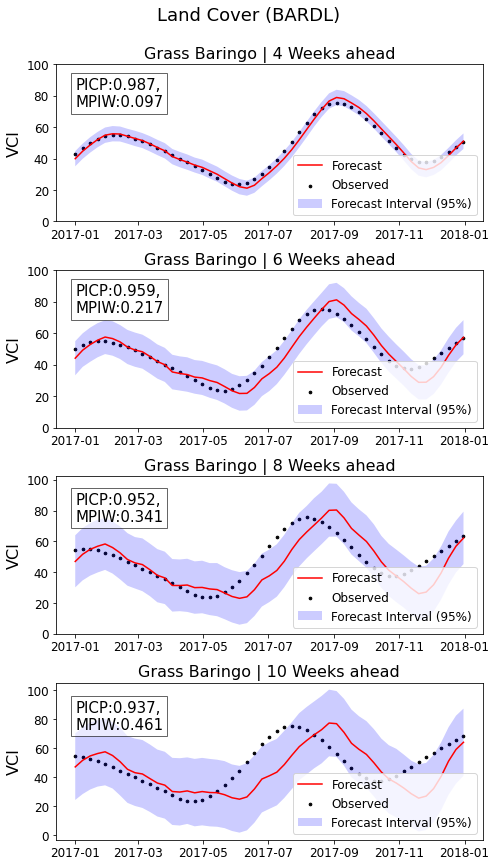

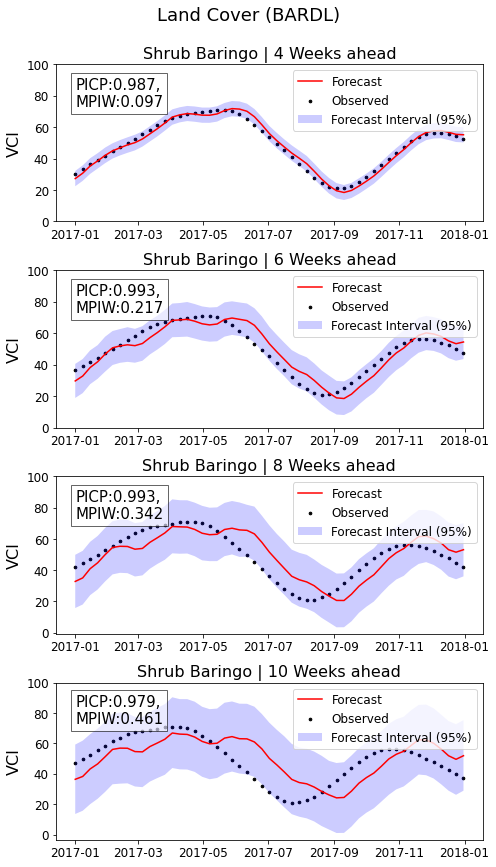

In [679]:
for r in lcs:
    coi = ['Baringo', f'{r}']
    select = []
    sub1 = UnPool_df[UnPool_df.County==coi[0]]
    # print(sub1)
    sub = sub1[sub1.LandCover==coi[1]]
    for h in [4,6,8,10,12]:
        select.append(sub[sub.Horizon==h])
    select_df = pd.concat(select)
    select_df['Date'] = pd.to_datetime(select_df.Date)
    select_df = select_df[select_df.Date.dt.year==2017]

#     date = pd.date_range(start='2018-01-07', end='2019-01-06', freq='W')
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7, 12))
    fig.suptitle(f'Land Cover (BARDL)', y=1.00, fontsize=18)
    for p, ax in enumerate(axs.reshape(-1)):
        hor = [4,6,8,10][p]
        pred_sub = select_df[select_df['Horizon']==hor]

        cp = UPICP_county[(UPICP_county['County']==coi[0])&(UPICP_county['LC']==coi[1])][f'PICP_{hor}'].values[0]
        iw = UPICP_county[(UPICP_county['County']==coi[0])&(UPICP_county['LC']==coi[1])][f'MPIW_{hor}'].values[0]
        mae2 = mean_absolute_error(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
        r2 = r2_score(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
        ax.set_title(f'{coi[1].capitalize()} {coi[0]} | {hor} Weeks ahead',fontsize=16)
        ax.scatter(pred_sub.Date, pred_sub.VCI_Observed*100, s=7, color='k', label='Observed')
        ax.plot(pred_sub.Date, pred_sub.VCI_Forecast*100, color='r', label='Forecast')
        ax.fill_between(pred_sub.Date, pred_sub.VCI_Upper1*100, pred_sub.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
        ax.set_ylabel('VCI',fontsize=16)
        ax.set_yticks(np.arange(0, 120, 20))
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        txt = ax.text(x=pred_sub.Date.values[0], y=73,
                          s=f'PICP:{cp.round(3)},\nMPIW:{iw.round(3)}',fontsize=15)
        txt.set_bbox(dict(facecolor='white', alpha=0.6))
        if r == 'shrub':
            ax.legend(loc='upper right', fontsize=12)
        elif r == 'crops':
            ax.legend(loc='upper right', fontsize=12)
        else:
            ax.legend(loc='lower right', fontsize=12)
        plt.tight_layout()
    plt.savefig(f'../UnPooled_PICP_MPIW_VCI3M_LC_{coi[1]}.pdf', dpi=300, bbox_inches='tight')

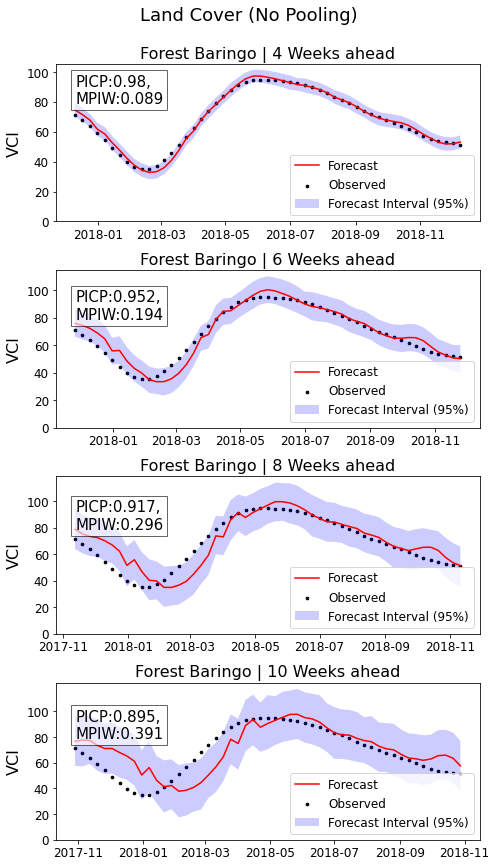

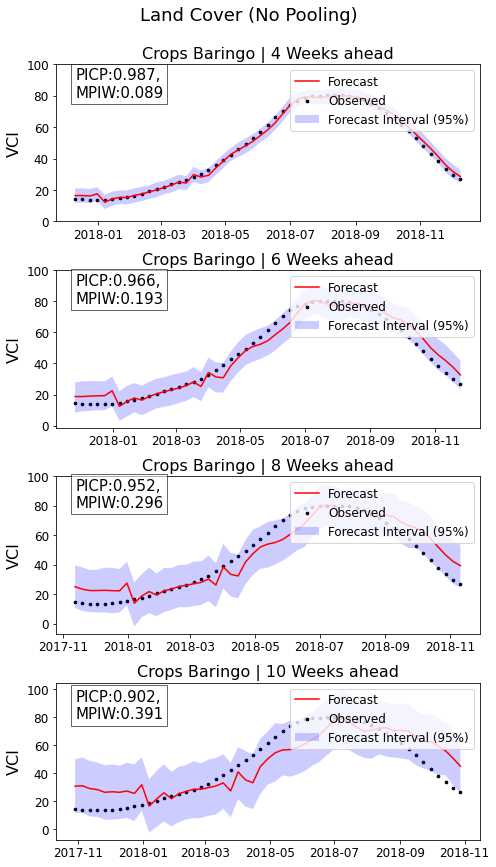

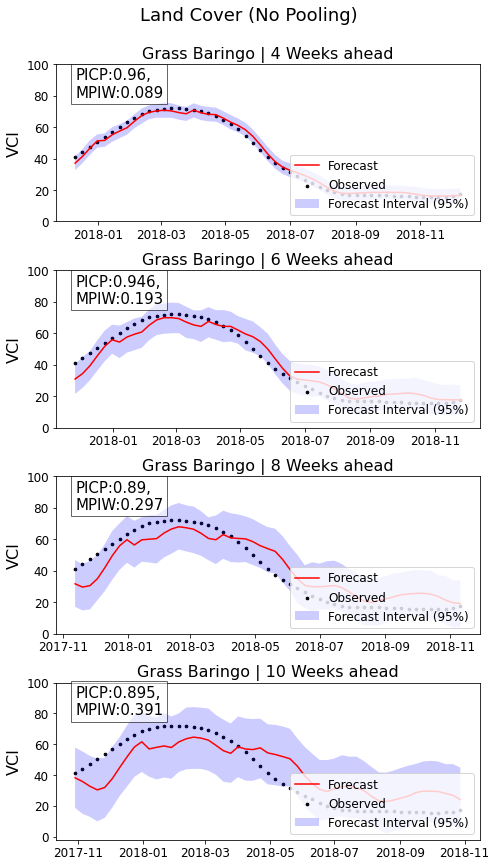

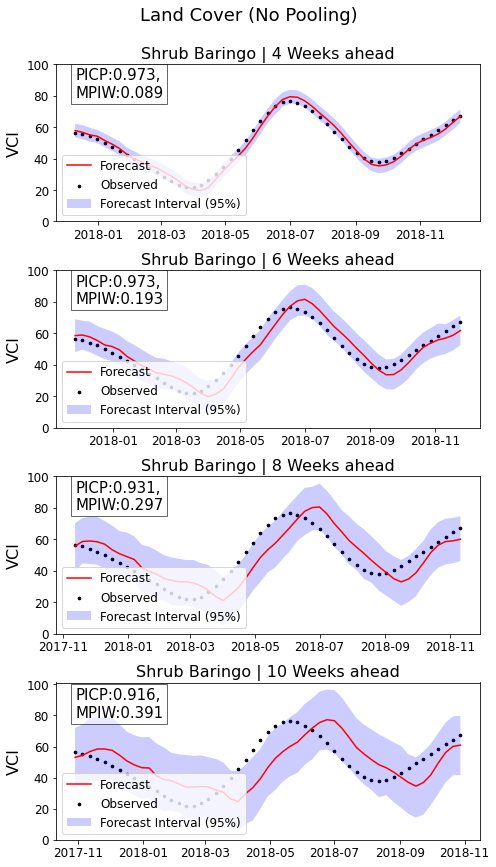

In [641]:
# for r in lcs:
#     coi = ['Baringo', f'{r}']
#     select = []
#     sub1 = PoolTr[PoolTr.County==coi[0]]
#     # print(sub1)
#     sub = sub1[sub1.LandCover==coi[1]]
#     for h in [4,6,8,10,12]:
#         select.append(sub[sub.Horizon==h][-53:])
#     select_df = pd.concat(select)
#     select_df['Date'] = pd.to_datetime(select_df.Date)

#     # date = pd.date_range(start='2018-01-07', end='2019-01-06', freq='W')
#     fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7, 12))
#     fig.suptitle(f'Land Cover (No Pooling)', y=1.00, fontsize=18)
#     for p, ax in enumerate(axs.reshape(-1)):
#         hor = [4,6,8,10][p]
#         pred_sub = select_df[select_df['Horizon']==hor]
#     #     pred_sub['Date'] = date
#         cp = PICP_county[(PICP_county['County']==coi[0])&(PICP_county['LC']==coi[1])][f'PICP_{hor}'].values[0]
#         iw = PICP_county[(PICP_county['County']==coi[0])&(PICP_county['LC']==coi[1])][f'MPIW_{hor}'].values[0]
#         mae2 = mean_absolute_error(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
#         r2 = r2_score(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)

#         ax.set_title(f'{coi[1].capitalize()} {coi[0]} | {hor} Weeks ahead',fontsize=16)
#         ax.scatter(pred_sub.Date, pred_sub.VCI_Observed*100, s=7, color='k', label='Observed')
#         ax.plot(pred_sub.Date, pred_sub.VCI_Forecast*100, color='r', label='Forecast')
#         ax.fill_between(pred_sub.Date, pred_sub.VCI_Upper1*100, pred_sub.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
#         ax.set_ylabel('VCI',fontsize=16)
#         ax.set_yticks(np.arange(0, 120, 20))
#         ax.tick_params(axis='x', labelsize=12)
#         ax.tick_params(axis='y', labelsize=12)
#         txt = ax.text(x=pred_sub.Date.values[0], y=79,
#                           s=f'PICP:{cp.round(3)},\nMPIW:{iw.round(3)}',fontsize=15)
#         txt.set_bbox(dict(facecolor='white', alpha=0.6))
#         if r == 'shrub':
#             ax.legend(loc='lower left', fontsize=12)
#         elif r == 'crops':
#             ax.legend(loc='upper right', fontsize=12)
#         else:
#             ax.legend(loc='lower right', fontsize=12)
#         plt.tight_layout()
#     plt.savefig(f'../Pooled_PICP_MPIW_VCI3M_LC_{coi[1]}.pdf', dpi=300, bbox_inches='tight')

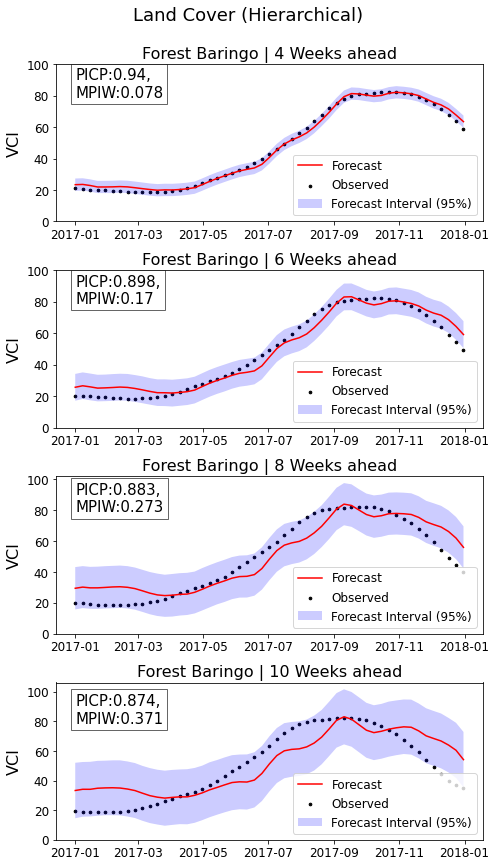

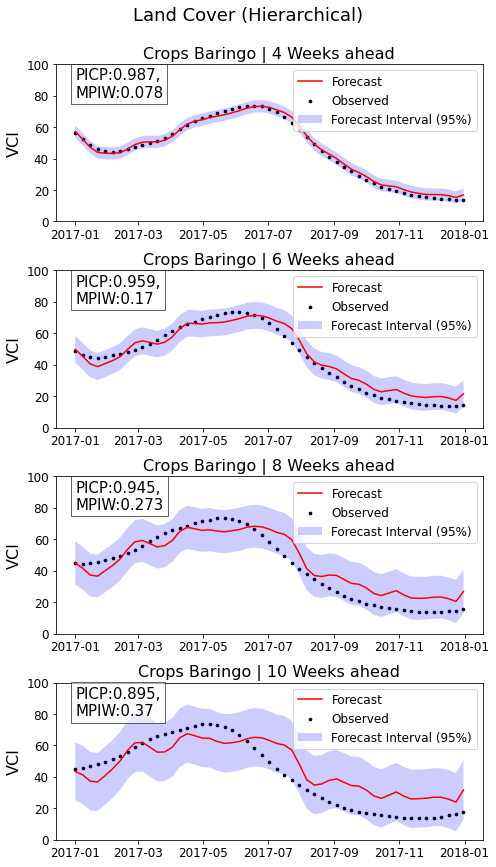

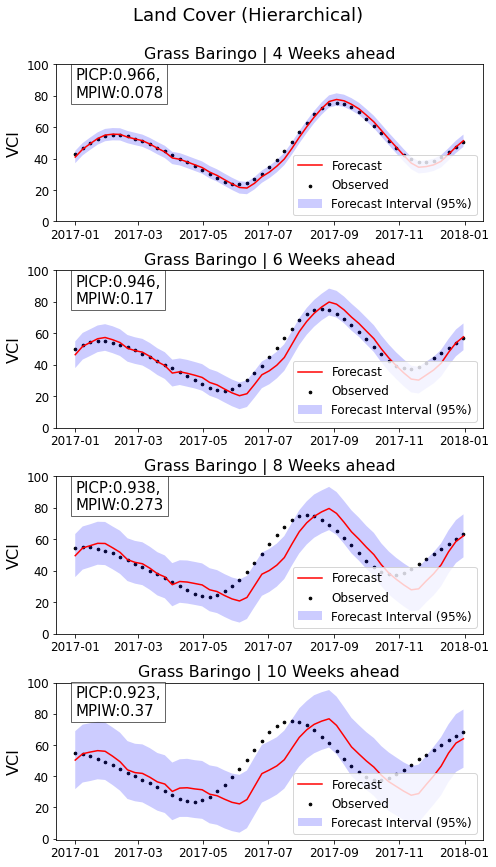

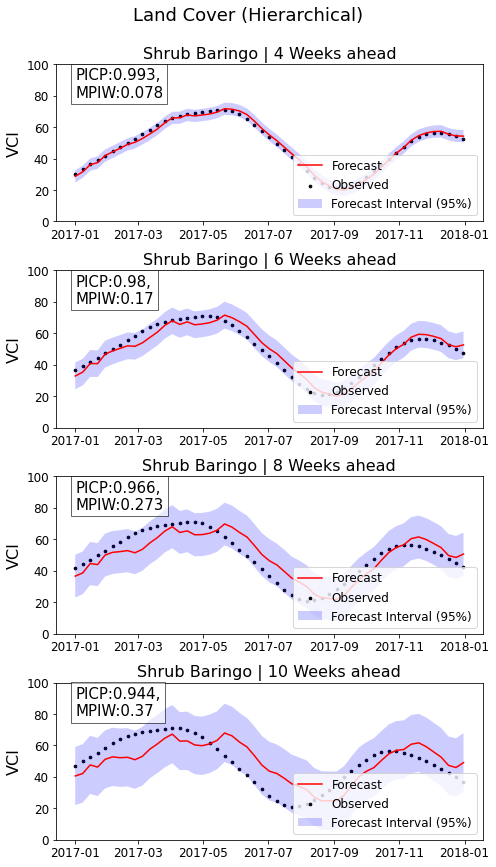

In [680]:
for r in lcs:
    coi = ['Baringo', f'{r}']
    select = []
    sub1 = PartPoolTr[PartPoolTr.County==coi[0]]
    # print(sub1)
    sub = sub1[sub1.LandCover==coi[1]]
    for h in [4,6,8,10,12]:
        select.append(sub[sub.Horizon==h])
    select_df = pd.concat(select)
    select_df['Date'] = pd.to_datetime(select_df.Date)
    select_df = select_df[select_df.Date.dt.year==2017]

    # date = pd.date_range(start='2018-01-07', end='2019-01-06', freq='W')
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7, 12))
    fig.suptitle(f'Land Cover (Hierarchical)', y=1.00, fontsize=18)
    for p, ax in enumerate(axs.reshape(-1)):
        hor = [4,6,8,10][p]
        pred_sub = select_df[select_df['Horizon']==hor]
    #     pred_sub['Date'] = date
        cp = PPICP_county[(PPICP_county['County']==coi[0])&(PPICP_county['LC']==coi[1])][f'PICP_{hor}'].values[0]
        iw = PPICP_county[(PPICP_county['County']==coi[0])&(PPICP_county['LC']==coi[1])][f'MPIW_{hor}'].values[0]
        mae2 = mean_absolute_error(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)
        r2 = r2_score(pred_sub.VCI_Observed.values, pred_sub.VCI_Forecast.values)

        ax.set_title(f'{coi[1].capitalize()} {coi[0]} | {hor} Weeks ahead',fontsize=16)
        ax.scatter(pred_sub.Date, pred_sub.VCI_Observed*100, s=7, color='k', label='Observed')
        ax.plot(pred_sub.Date, pred_sub.VCI_Forecast*100, color='r', label='Forecast')
        ax.fill_between(pred_sub.Date, pred_sub.VCI_Upper1*100, pred_sub.VCI_Lower0*100, facecolor='blue', alpha=0.2, label='Forecast Interval (95%)')
        ax.set_ylabel('VCI',fontsize=16)
        ax.set_yticks(np.arange(0, 120, 20))
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        txt = ax.text(x=pred_sub.Date.values[0], y=79,
                          s=f'PICP:{cp.round(3)},\nMPIW:{iw.round(3)}',fontsize=15)
        txt.set_bbox(dict(facecolor='white', alpha=0.6))
        if r == 'shrub':
            ax.legend(loc='lower right', fontsize=12)
        elif r == 'crops':
            ax.legend(loc='upper right', fontsize=12)
        elif r == 'grass':
            ax.legend(loc='lower right', fontsize=12)
        else:
            ax.legend(loc='lower right', fontsize=12)
        plt.tight_layout()
    plt.savefig(f'../Hierarchical_PICP_MPIW_VCI3M_LC_{coi[1]}.pdf', dpi=300, bbox_inches='tight')